# Salary investigation
This work aims to build a model that can predict whether a person earns more than 50K or not based on the provided features

In [325]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
# sklearn.set_config(print_changed_only=True)
%matplotlib inline

# Data visualisation part

In [326]:
df = pd.read_csv("data/adult.csv", index_col=0)
df['income'] = df['income'].str.replace(" ", "")
df.head()

# Think for this data, because the target column (income) is a binary value, using x-y plot is difficult to 
# see the relationship between x and y. I think it is better to use histogram, with y as colors

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [327]:
# Make df income to 0 or 1 (less than or greater than 50K)
df_process = df.copy()
# It is found that some of the entries have space. Use .strip() function to get rid of any leading or trailing space
df_process.applymap(lambda x: str(x).strip())

df_process['income'] = pd.get_dummies(df['income'])
# print(df_process['income'])
# df[df['income'] == '<=50K']['income'].value_counts().values[0]

## Some initial categorisation of the features
All features:
* Workclass (categorical)
* education (categorical)
* marital-status (categorical)
* occupation (categorical)
* relationship (categorical)
* race (categorical)
* gender (categorical)

* native-country (categorical with engineering)


* age (numerical values)
* education-num (numerical values)
* hours-per-week (numerical values)
* capital-gain (numerical values)
* capital-loss (numerical values)

Classification of features
Categorical features: education, marital-status, occupation, relationship, race, gender, workclass<br>
Categorical with engineering: native-country (original; native or non-native to US, groupby continent)<br>
Numerical values: education-num, capital-gain, capital-loss, hours-per-week, age

**All numerical values can potentially be binned<br>
All categorical features will be encoded by one-hot encoding**<br>

Can use a simple percentage method to identify column groups that have high/low ratios of <=50k and >50k



### Age groups and the ratio of high and low salary 
I want to visualise how the ratios of high and low salary change among different age group.
Therefore, a custom plot function that does a bar plot to put both high and low salary frequency next to each other at each age group

In [328]:
import math
from colour import Color

# Making this into a function so that we can put in different columes to plot against
# The function would return the groupby df so that one can plot individual group themselves
def plot_col_against_income(df, col, col_first=True, labels='', reindex_list=''):
    # If col_first is true, would grouby the column first, followed by income
    
    
    if col_first == True:
        df_col_income_groupby = df.groupby([col, 'income'])['age'].count().unstack() 
    # For count, I don't think it matters which column I choose
    
    else:
        df_col_income_groupby = df.groupby(['income', col])['age'].count().unstack()
        
    df_col_income_groupby.index = df_col_income_groupby.index.str.strip()
        
    if reindex_list:
        df_col_income_groupby = df_col_income_groupby.reindex(reindex_list)
                

    df_col_income_groupby.plot(kind='bar', figsize=(20,10))
    
    if labels:
        plt.xlabel(labels[0], fontsize=20)
        plt.ylabel(labels[1], fontsize=20)
    
    plt.show()
    
    return df_col_income_groupby

def plot_group_ratio(df_groupby, log_plot=True, labels='', reindex_list='', sort_val=False):
    # Get the ratios of those earning less than 50K against those earning more than 50K at different age groups
    ratio = df_groupby['<=50K']/df_groupby['>50K']
    
    for ind, row in df_groupby.iterrows():        
        # In some of the age groups, there are no people earning more than 50K, or vice versa. 
        # If that is the case, for less than 50K, let the ratio be the number of people earning less than 50K
        # For more than 50 K, let the ratio be the inverse of the number of people earning more than 50K
        if np.isnan(row['>50K']):
            ratio[ind] = row['<=50K']
        elif np.isnan(row['<=50K']):
            ratio[ind] = 1/row['>50K']
        
    log_ratio = np.log10(ratio)
    
    if sort_val:
        ratio = ratio.sort_values(ascending=False)
        log_ratio = log_ratio.sort_values(ascending=False)
    
    if reindex_list:
        ratio = ratio.reindex(reindex_list)
        log_ratio = log_ratio.reindex(reindex_list)
    
    
    ## Make a colour list so that the colour of the bar would be adjusted according to its value
    blue = Color("blue")
    color_range = 15
    colors = list(blue.range_to(Color("green"), color_range))
    color_list = []
    
    if log_plot:
        plot_ratio = log_ratio
    else:
        plot_ratio = ratio

    max_diff = max(plot_ratio) - min(plot_ratio)

    for r in plot_ratio:
        ind = int(math.floor(color_range - (r - min(plot_ratio))/max_diff*color_range))
        if ind < 0:
            ind = 0
        if ind > (color_range - 1):
            ind = (color_range - 1)
        color_list.append(colors[ind].rgb)

#     print(len(color_list))
    # print(len(age_ratio))
    

    
    if log_plot:
        log_ratio.plot.bar(figsize=(20,10), color=color_list)
        labels[1] = 'log(' + labels[1][0].lower() + labels[1][1:] + ')'
    else:
        ratio.plot.bar(figsize=(20,10), color=color_list)
        
    if labels:
        plt.xlabel(labels[0], fontsize=20)
        plt.ylabel(labels[1], fontsize=20)
        
    plt.show()
                  
    return ratio, log_ratio
    
# Set all plots' labelsize to be 20    
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

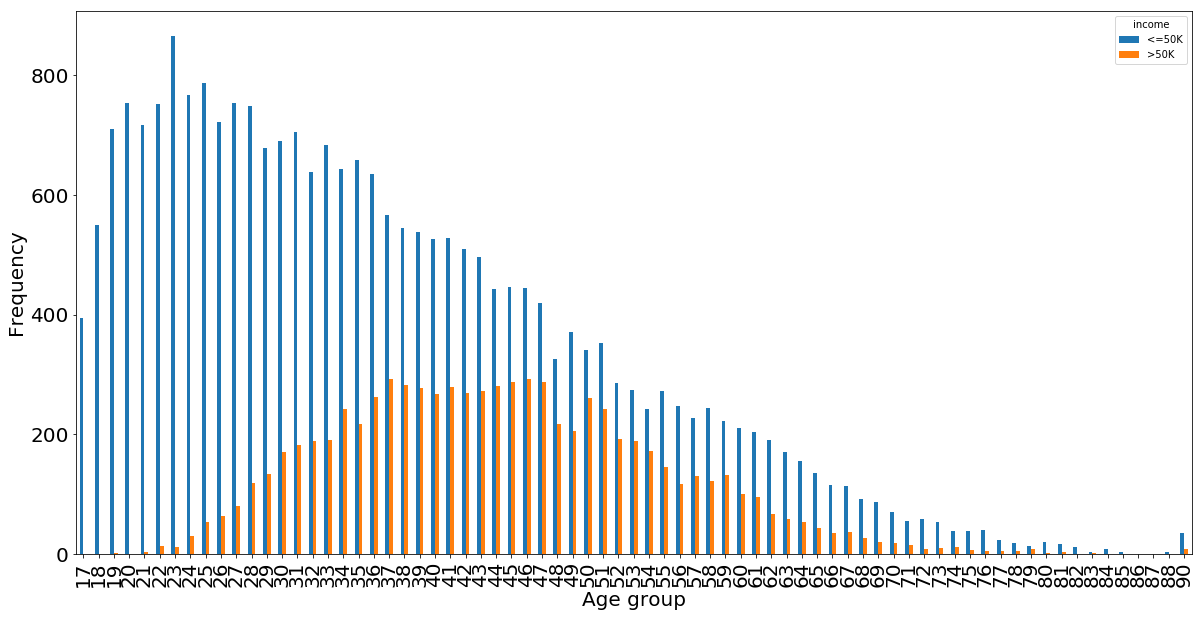

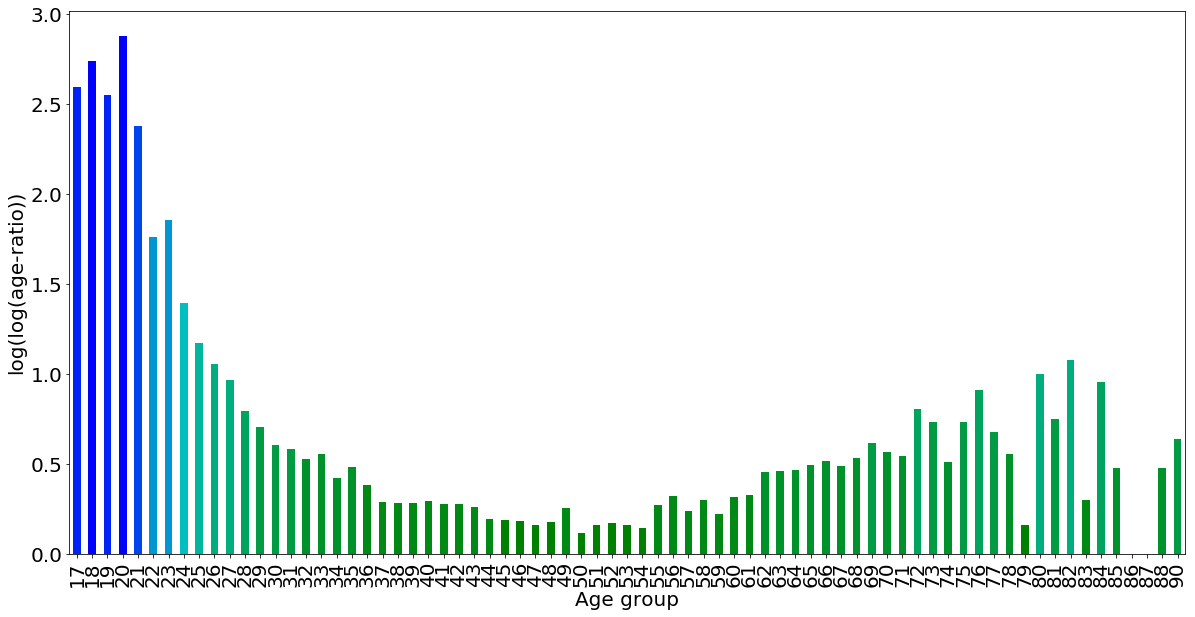

In [15]:
df_age_groupby = plot_col_against_income(df, 'age', labels=['Age group', 'Frequency'])
# plt.ylabel("Frequency", fontsize=20)
# plt.xlabel("Age group", fontsize=20)
# print(df_groupby.index)
# print(df_groupby.head())

age_ratio, age_log_ratio = plot_group_ratio(df_age_groupby, labels=['Age group', 'log(age-ratio)'])

#### Comment on the ratios at different age groups
It can be seen that in all age groups, the number of people earning less than 50K is always more than the number earning more than 50K.

In terms of the trend, the ratio is the highest at young age, and it gradually decreases as the age increases. This is reasonable as we know that one's salary should increase as his/her experiences grow. <br>
However, the ratio does not grow indefinitely. The ratio drops down to its minimum around 45 to 54, and then ratio starts to grow again.


The ratio increase is not as steep as the drop from young age to 50 though. For example, the ratio difference between the age group 25 (14.87) and 50 (1.31) is 13.47 times. On the other hand, the different between 50 (1.31) and 70 (3.684211) is 2.3742. 

For people over 50, it is perhaps that people getting higher salary are more likely to get laid-off as we hear from news. Other possibilities may be that, the people earning more think they have earnt enough to retire earlier.


Note that the number of samples dropped dramatically age 70. Therefore, the ratios after age 70 may not be as meaningful.

## Education-num plot

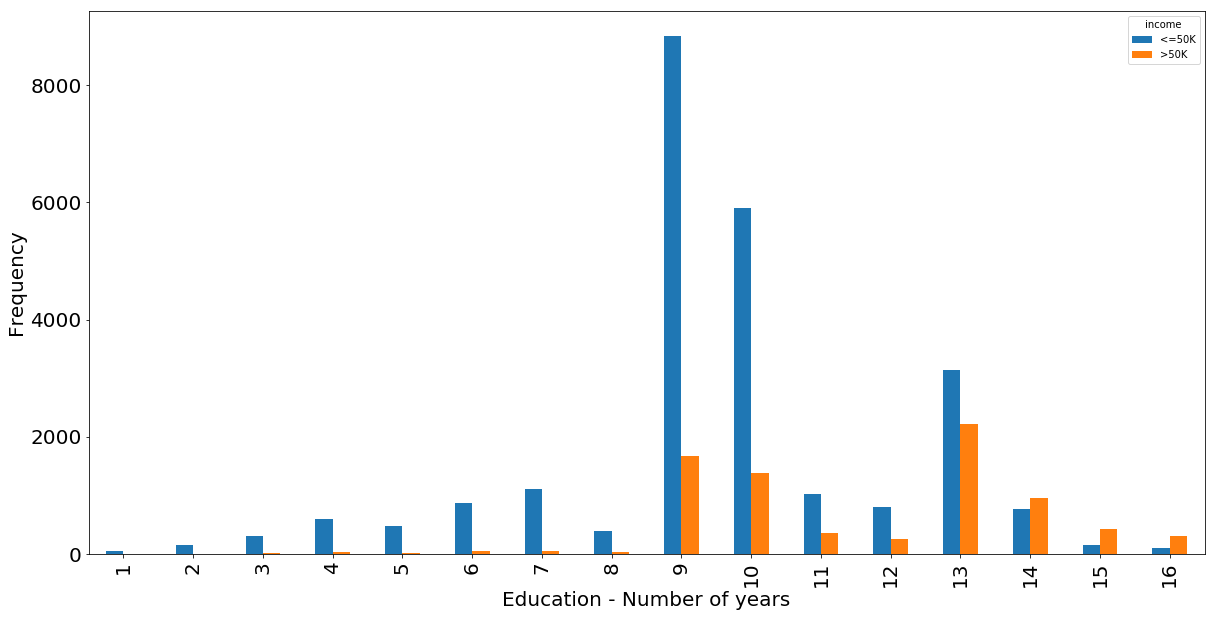

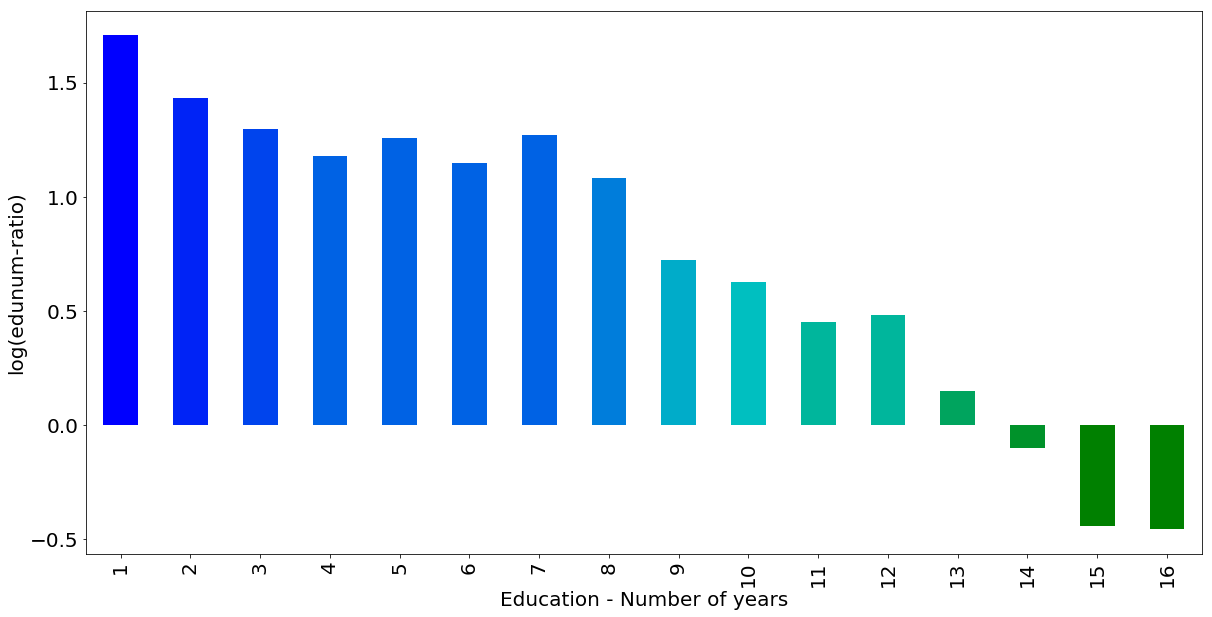

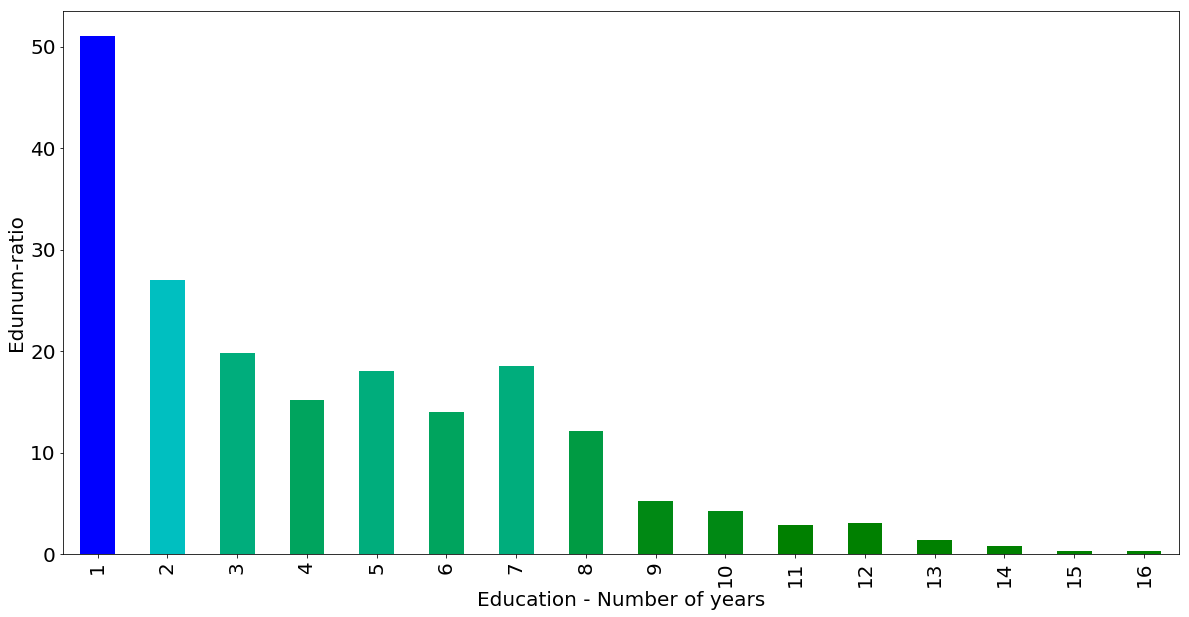

In [11]:
# edunum_income_groupby = df.groupby(['education-num', 'income'])['age'].count().unstack()
# income_edunum_groupby = df.groupby(['income', 'education-num'])['age'].count().unstack()
# # The order of income and education would affect the bar plot as demonstrated below
# # print(df.groupby(['education-num', 'income'])['age'].count().unstack())
# df_groupby = plot_col_against_income(df, 'education-num')

# # edunum_income_groupby.plot(kind='bar')
# # income_edunum_groupby.plot(kind='bar')

df_edunum_groupby = plot_col_against_income(df, 'education-num', labels=['Education - Number of years', 'Frequency'])
# print(df_groupby.index)
# print(df_groupby.head())

plot_group_ratio(df_edunum_groupby, log_plot=True,\
                                                  labels=['Education - Number of years', 'Edunum-ratio'])

plot_group_ratio(df_edunum_groupby, log_plot=False, labels=['Education - Number of years', 'Edunum-ratio'])

**Comments on the ratio of the education number**<br>
The overall trend of the ratio decreases as the number of education increases.


There are 3 big drops in the ratios, between 1 and 2 years, 8 and 9 years and 12 and 13 years.


1. For the first big drop, it is not clear why it is so. Perhaps some fundamental skills are taught in the first 2 years, so  lacking 1 year education can severely affect a person's working skills. <br>
2. For the second drop, 9 years of education usually correspond to finishing junior high school. For current education system, certification is quite valued in the job market. Therefore, the big drop might reflect the value of that certification. <br>
3. For the 3rd drop, it happens between year 12 and 13, instead of year 11 and 12 years of education. This suggests that the certification at finishing senior high school is probably not as significant in the job market as the junior high school certification. However, being able to start year 13 usually means that one becomes a bachelor degree candidate, which means he/she has been assessed at the SAT and is more likely to be qualified for high paying jobs.

Note that the overall number of people decreases after 13 years of education (as seen in the first figure). This may be reflecting some drop-outs from the university. Interestingly, the log ratio reverses after 14 years of education, meaning there are more people earning >50K in these categories as seen in the second figure. <br>
Another interesting finding is that there are much fewer people in 11 and 12 years of categories compared to 10 and 13 years. This may mean that people who have finished 10 years of education and continued pursuing education tends to get pass at least 13 years of education, i.e., entering University.

## Hours per week plot

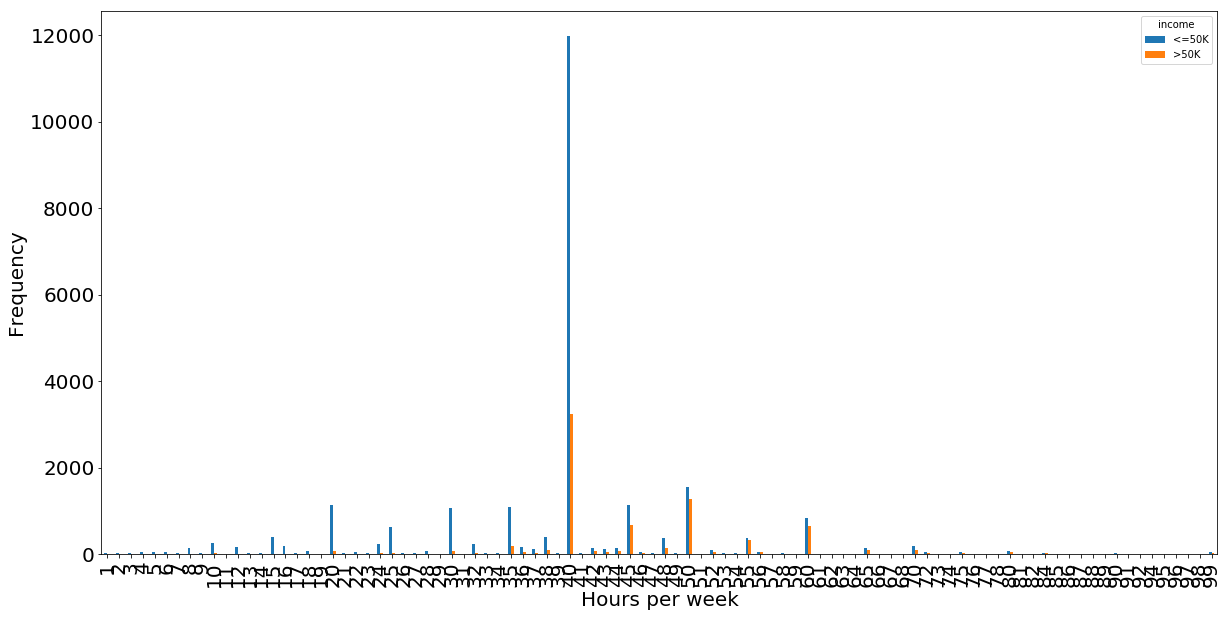

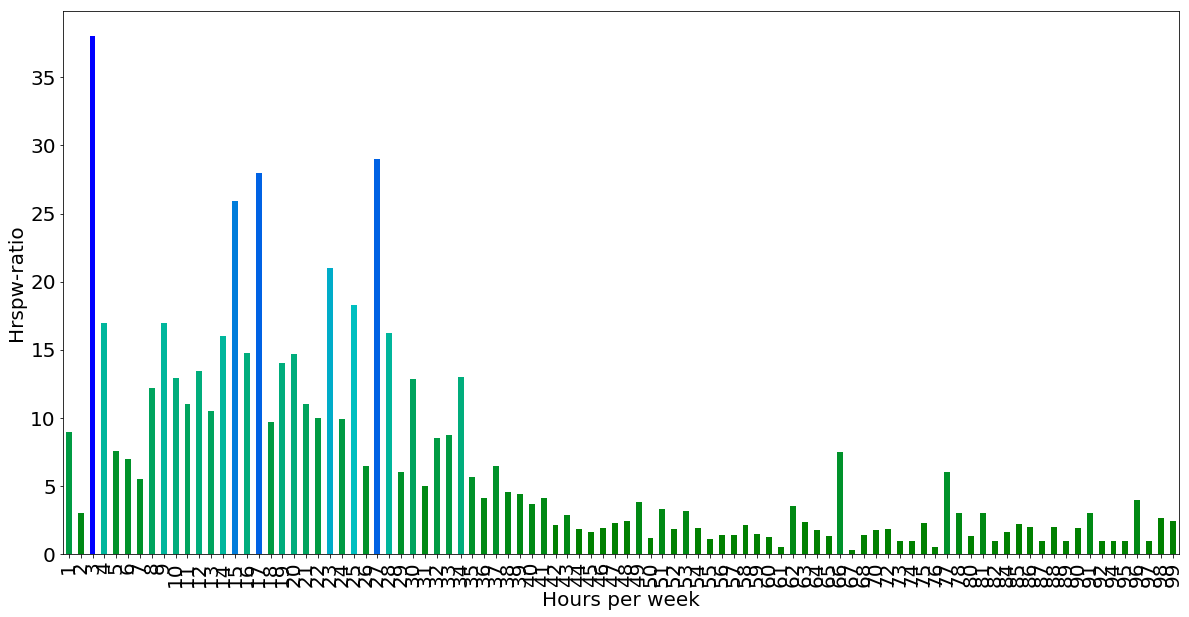

In [12]:
df_hrspw_groupby = plot_col_against_income(df, 'hours-per-week', labels=['Hours per week', 'Frequency'])



plot_group_ratio(df_hrspw_groupby, log_plot=False,\
                                                  labels=['Hours per week', 'Hrspw-ratio'])

**Comment on hours per week** <br>
There are much more people in the 40 hours-per-week category. This is reasonable since that is usually the working hours (9-5, 8 hours per day) for most people.

People working less or more than 40 hours-per-week (but not equal to 40) are scattered at different hours-per-week categories. Therefore, for each category, the number of people is much less. However, a trend can still be observed that the ratios are higher for people working less than 40 hours-per-week. It is a bit difficult to tell the ratios for people working more than 40 hours-per-week because of the fluctuation in different categories.

To overcome the problem of not being able to tell whether people working less/more than 40 hours-per-week earn more or less than 50K, the number of people at different categories are aggregated to 3 categories for clear analysis: <40, =40 and >40 hours-per-week.

### Hours per week plot with 3 aggregated categories (<40, 40 and >40 hours-per-week)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


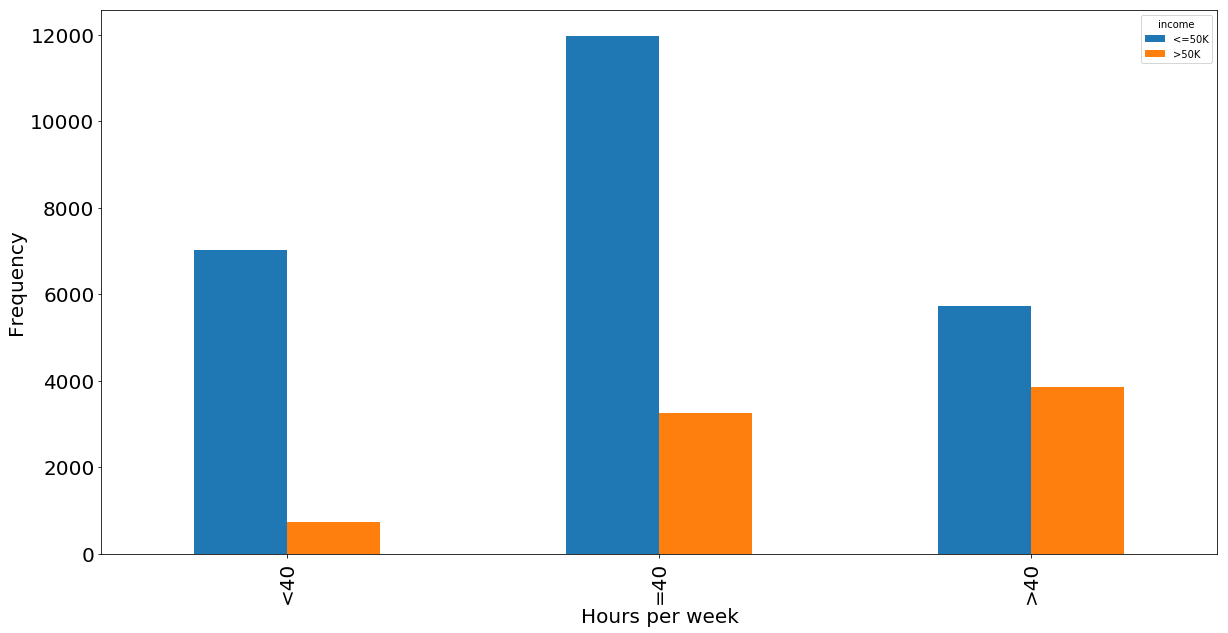

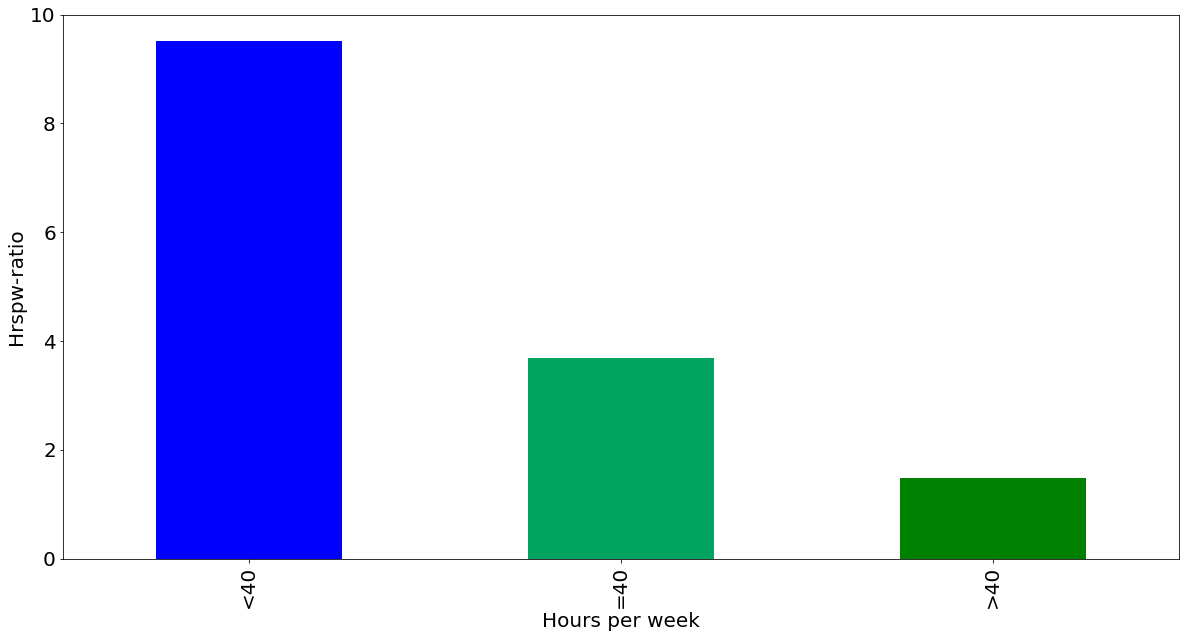

In [90]:
df_hrs_temp = df.copy()

df_hrs_temp['hours-per-week-transformed'] = df_hrs_temp['hours-per-week']

df_hrs_temp['hours-per-week-transformed'].loc[df_hrs_temp['hours-per-week'] < 40] = '<40'
df_hrs_temp['hours-per-week-transformed'].loc[df_hrs_temp['hours-per-week'] == 40] = '=40'
df_hrs_temp['hours-per-week-transformed'].loc[df_hrs_temp['hours-per-week'] > 40] = '>40'

# df_hrs_temp.head(50)

reindex_list = ['<40', '=40', '>40']


df_hrspw_transformed_groupby = plot_col_against_income(df_hrs_temp, 'hours-per-week-transformed',\
                                                       labels=['Hours per week', 'Frequency'], reindex_list=reindex_list)

hrspw_ratio, hrspw_log_ratio = plot_group_ratio(df_hrspw_transformed_groupby, log_plot=False,\
                                                  labels=['Hours per week', 'Hrspw-ratio'], reindex_list=reindex_list)

**Comment on hours per week with the 3 categories** <br>
With the number of people aggregated into the <40, 40 and >40 hours-per-week categories defined, it is clearer to see that the ratios is the highest when the hours-per-week is less than 40, and the ratio becomes the lowest when the hours-per-week is more than 40.

This observation may be reasonable because given the hourly rate is the same, the more hours one works, the more he/she earns. In addition to that, people working less than 40 hours may more likely do part-time jobs rather than full-time jobs. Although there are premiums of casual workers over non-casual (see http://theconversation.com/the-costs-of-a-casual-job-are-now-outweighing-any-pay-benefits-82207), it is not enough to compensate for less hours and the nature of low wage for most of part-time jobs (see https://www.theguardian.com/money/2014/nov/28/faces-us-recovery-low-paid-part-time-jobs). 

For people working less than 40 hours-per-week and earning more than 50k, it is likely that the job has a high hourly paying rate. However, this kind of jobs usually requires skills (usually in the healthcare industry, as shown in https://www.monster.com/career-advice/article/high-paying-part-time-jobs-0817), so it is not surprising that the number of people in this category is low, further increasing the ratio between the number of people earning less than 50K and more than 50K.

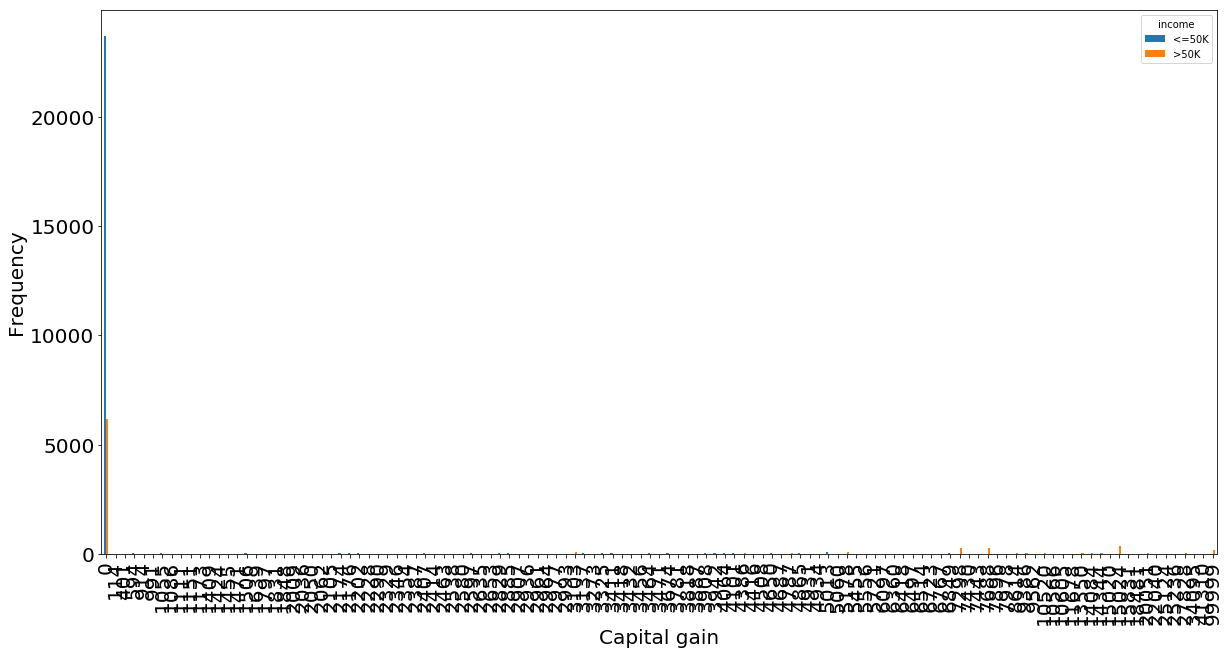

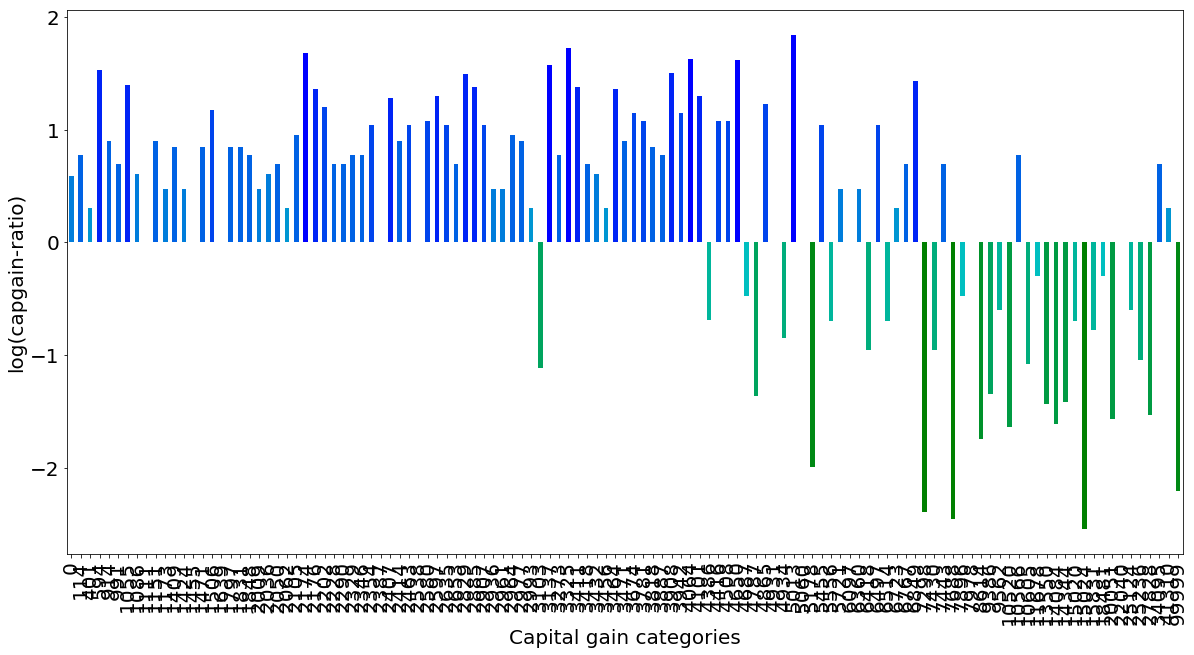

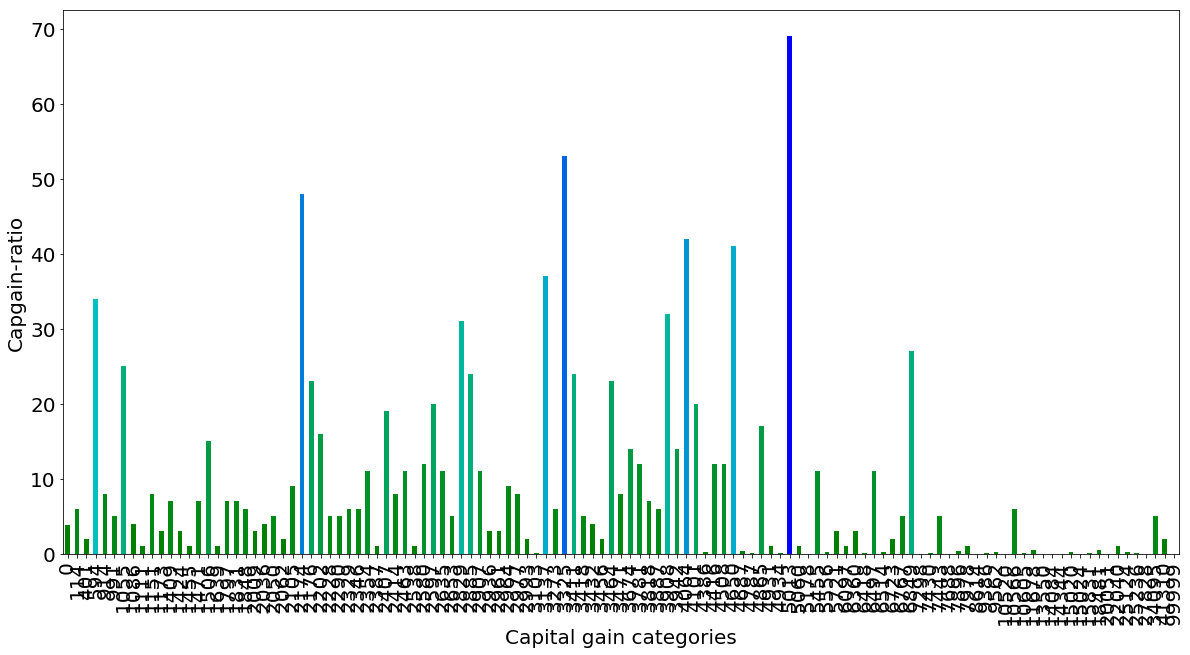

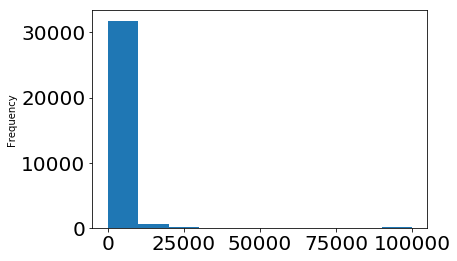

In [43]:
df_cap_gain_groupby = plot_col_against_income(df, 'capital-gain', labels=['Capital gain', 'Frequency'])
# print(df_groupby.index)
# print(df_groupby.head())

plot_group_ratio(df_cap_gain_groupby, log_plot=True,\
                                                  labels=['Capital gain categories', 'Capgain-ratio'])

capgain_ratio, capgain_log_ratio = plot_group_ratio(df_cap_gain_groupby, \
                                                    log_plot=False, labels=['Capital gain categories', 'Capgain-ratio'])

df['capital-gain'].plot(kind='hist')

29849


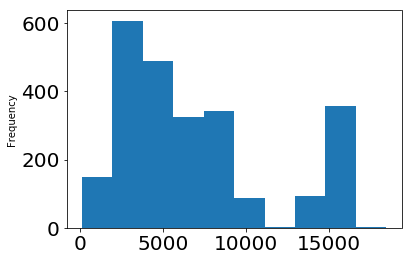

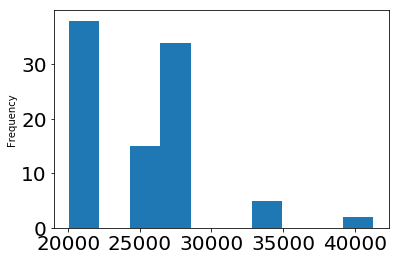

159


In [67]:
print(len(df['capital-gain'].loc[df['capital-gain'] == 0]))

df['capital-gain'].loc[(df['capital-gain']<20000) & (df['capital-gain']>0)].plot(kind='hist')
plt.show()

df['capital-gain'].loc[(df['capital-gain']<50000) & (df['capital-gain']>=20000)].plot(kind='hist')
plt.show()

# There is no value between 50,000 and 99,999. So for the number of people over 50,000, just print len
print(len(df['capital-gain'].loc[df['capital-gain']>=50000]))
# df['capital-gain'].loc[df['capital-gain']>=50000].plot(kind='hist')




**Comment on capital-gain**<br>
Based on the histogram results, there are much more people getting 0 capital gain than the other categories.
For people who have positive gain, there are much more people getting less than \$20,000 than those getting more than \$20,000.

To get a clear analysis, a new binning method is use to aggregate people with the following categories:
* 0
* 1,000 to 20,000 with 1,000 interval
* 20,000 to 50,000 with 5,0000 interval
* more than 50,000


31042


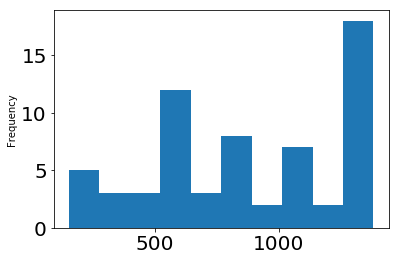

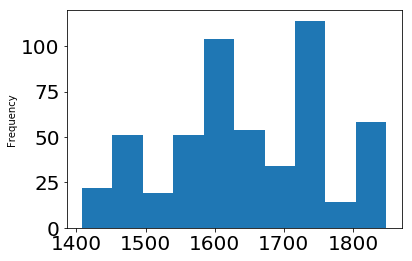

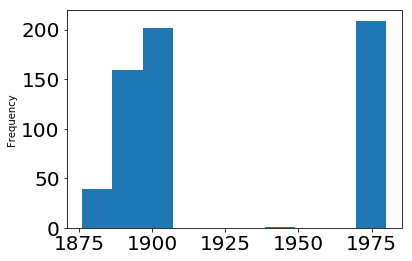

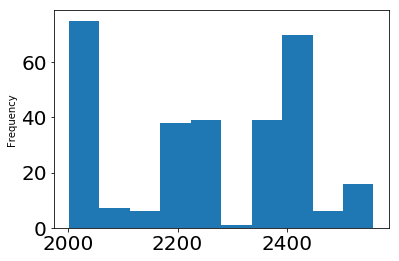

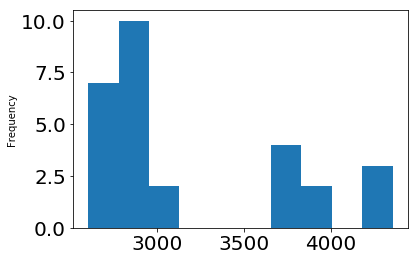

In [83]:
print(len(df['capital-loss'].loc[df['capital-loss'] == 0]))

df['capital-loss'].loc[(df['capital-loss']<1400) & (df['capital-loss']>0)].plot(kind='hist')
plt.show()

df['capital-loss'].loc[(df['capital-loss']<1850) & (df['capital-loss']>=1400)].plot(kind='hist')
plt.show()

df['capital-loss'].loc[(df['capital-loss']<2000) & (df['capital-loss']>=1850)].plot(kind='hist')
plt.show()

df['capital-loss'].loc[(df['capital-loss']<2600) & (df['capital-loss']>=2000)].plot(kind='hist')
plt.show()

df['capital-loss'].loc[df['capital-loss']>=2600].plot(kind='hist')

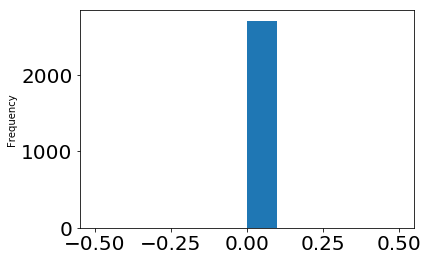

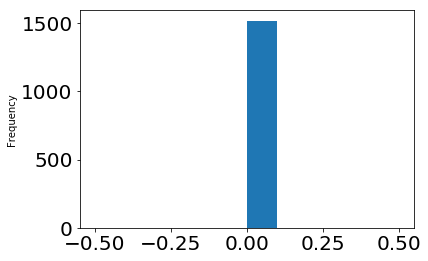

In [73]:
# Check if capital gain and capital loss are cancelled out or not before these values are set
df['capital-loss'].loc[df['capital-gain']> 0].plot(kind='hist')
plt.show()
df['capital-gain'].loc[df['capital-loss']> 0].plot(kind='hist')

**Comment on capital-gain and capital-loss values when its oposite is more than 0** <br>
From the figures above, it can be shown that, people with capital-gain > 0 has 0 capital-loss and vice versa.<br>
This means that capital-gain and capital-loss do not have be cancelled out in this process.

## Visualisation of categorical values
* Workclass (categorical)
* education (categorical)
* marital-status (categorical)
* occupation (categorical)
* relationship (categorical)
* race (categorical)
* gender (categorical)
* native-country (categorical with engineering)


### Education category plot

income          <=50K    >50K
education                    
 10th           871.0    62.0
 11th          1115.0    60.0
 12th           400.0    33.0
 1st-4th        162.0     6.0
 5th-6th        317.0    16.0
 7th-8th        606.0    40.0
 9th            487.0    27.0
 Assoc-acdm     802.0   265.0
 Assoc-voc     1021.0   361.0
 Bachelors     3134.0  2221.0
 Doctorate      107.0   306.0
 HS-grad       8826.0  1675.0
 Masters        764.0   959.0
 Preschool       51.0     NaN
 Prof-school    153.0   423.0
 Some-college  5904.0  1387.0
['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
Index(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th',
       '12th', 'HS-grad', 'Some-college', 'Assoc-acdm', 'Assoc-voc',
       'Bachelors', 'Masters', 'Prof-school', 'Doctorate'],
      dtype='object', name='education')


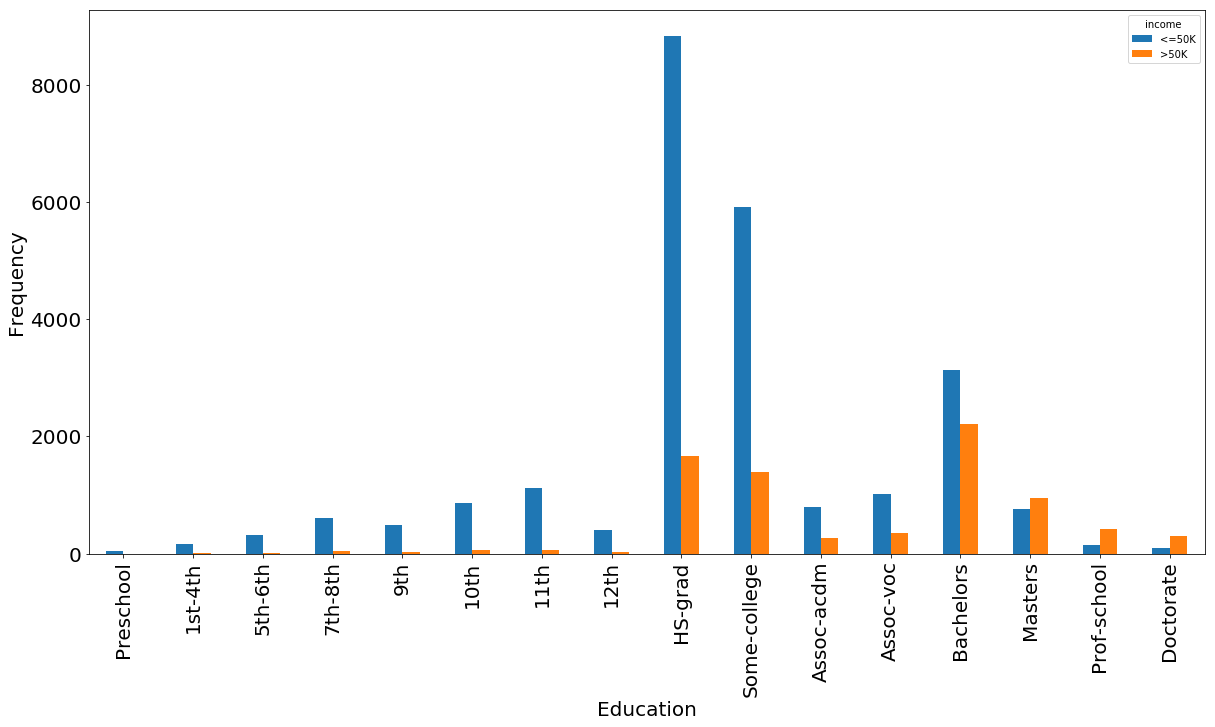

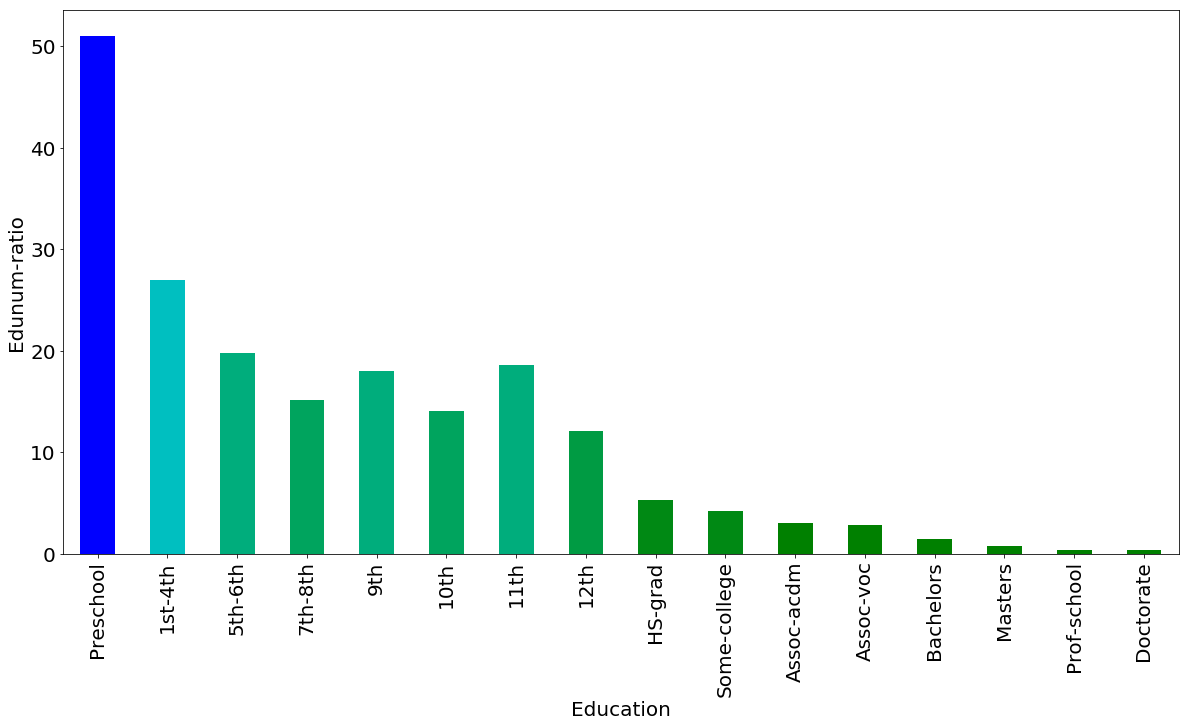

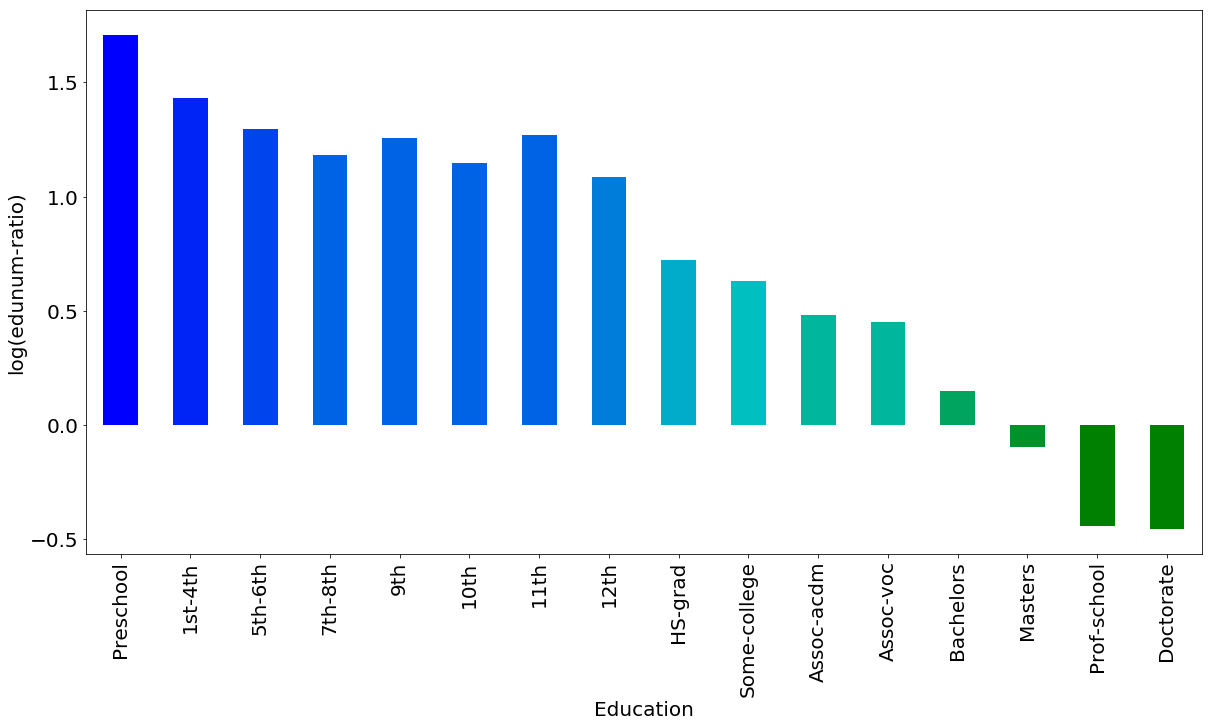

In [115]:
# Want to get how many people in each category of a column has income less than or greater than 50K
# For example, for education-num = 1, how many has income greater than 50k, and how many less than

edu_income_groupby = df.groupby(['education', 'income'])['age'].count().unstack()
income_edu_groupby = df.groupby(['income', 'education'])['age'].count().unstack()
# The order of income and education would affect the bar plot as demonstrated below
print(df.groupby(['education', 'income'])['age'].count().unstack())


reindex_list = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',\
               'Some-college', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate'] 

df_edu_groupby = plot_col_against_income(df, 'education', labels=['Education', 'Frequency'], reindex_list=reindex_list)

plot_group_ratio(df_edu_groupby, log_plot=False,\
                                                  labels=['Education', 'Edunum-ratio'], reindex_list=reindex_list)

edu_ratio, edu_log_ratio = plot_group_ratio(df_edu_groupby, log_plot=True, labels=['Education', 'Edunum-ratio'],\
                                           reindex_list=reindex_list)


### Gender plot

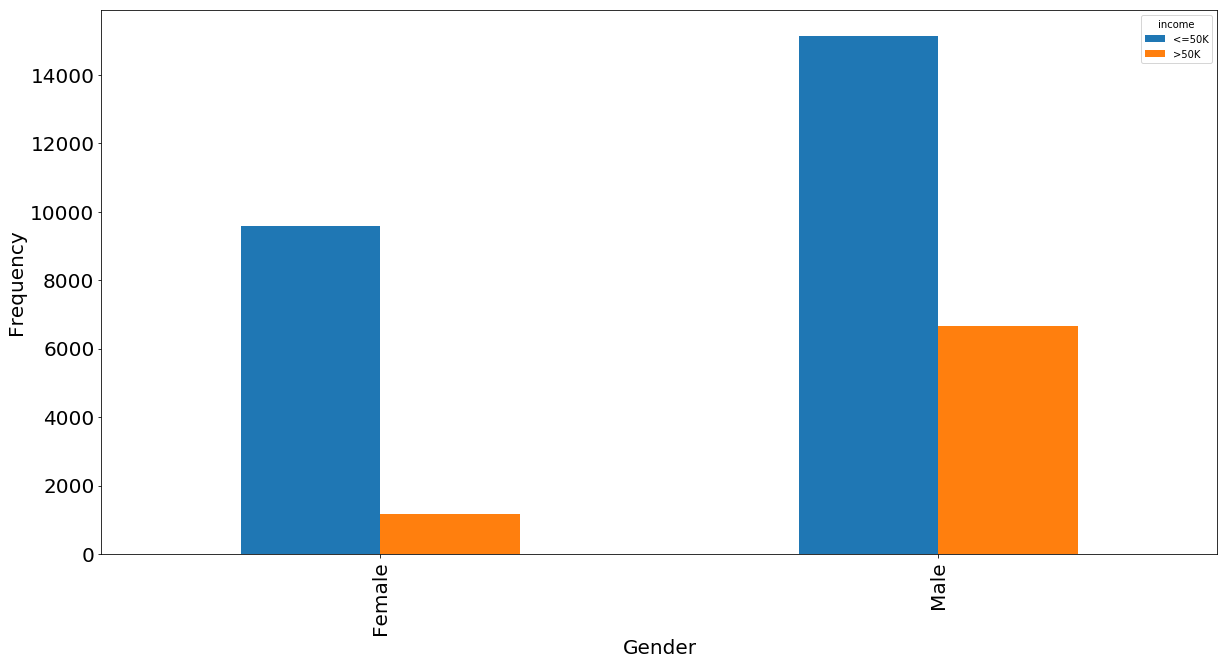

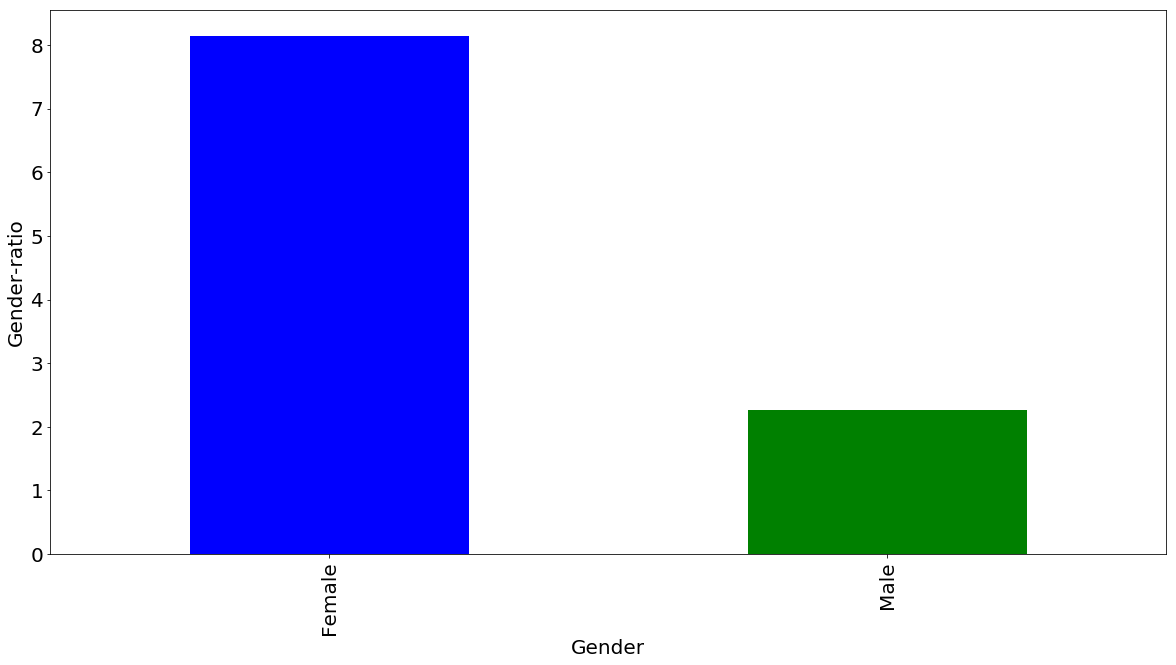

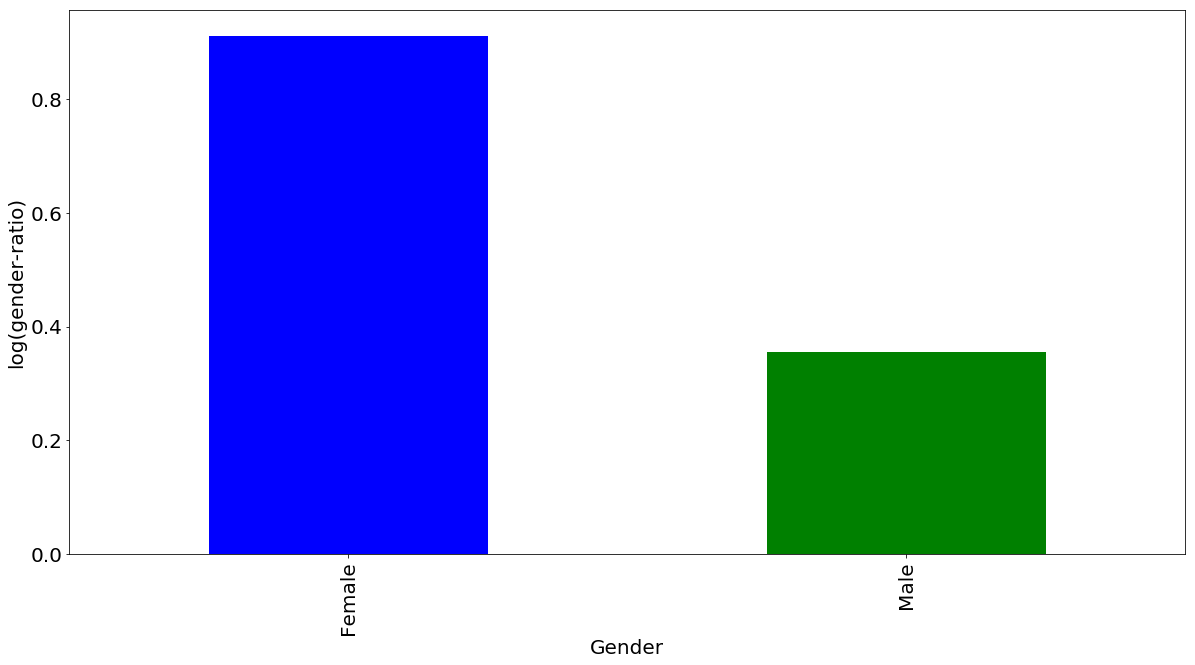

In [118]:
df_gen_groupby = plot_col_against_income(df, 'gender', labels=['Gender', 'Frequency'])

plot_group_ratio(df_gen_groupby, log_plot=False,\
                                                  labels=['Gender', 'Gender-ratio'])

gen_ratio, gen_log_ratio = plot_group_ratio(df_gen_groupby, log_plot=True, labels=['Gender', 'Gender-ratio'])

**Comment on gender plot** <br>
The female ratio is higher than the male ratio. This can the gender inequality where female earns less than male in general.

### Workclass plot

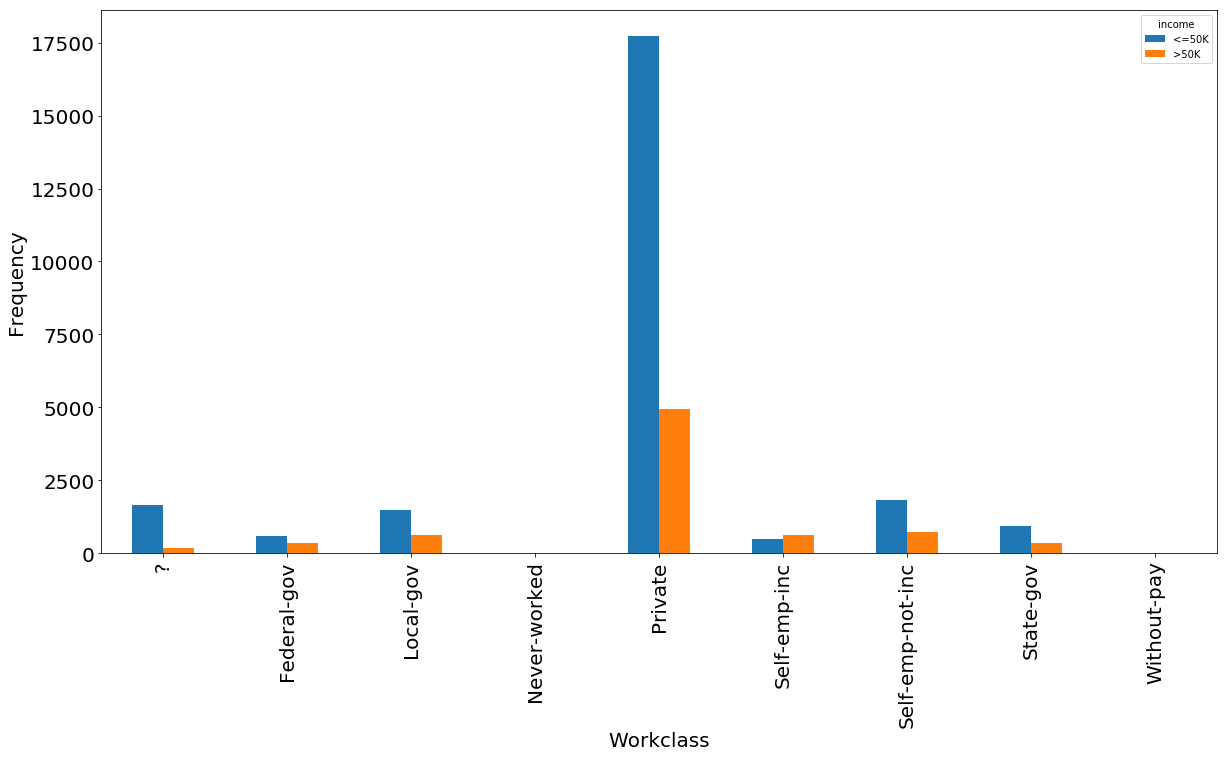

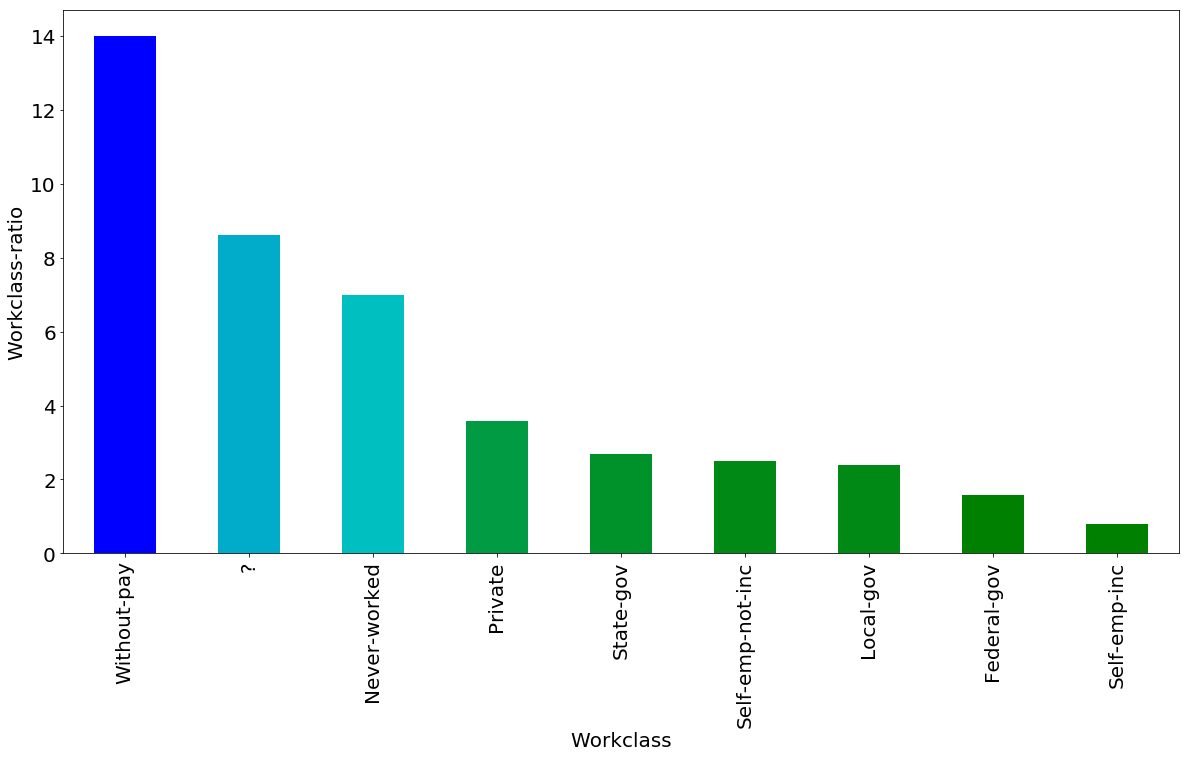

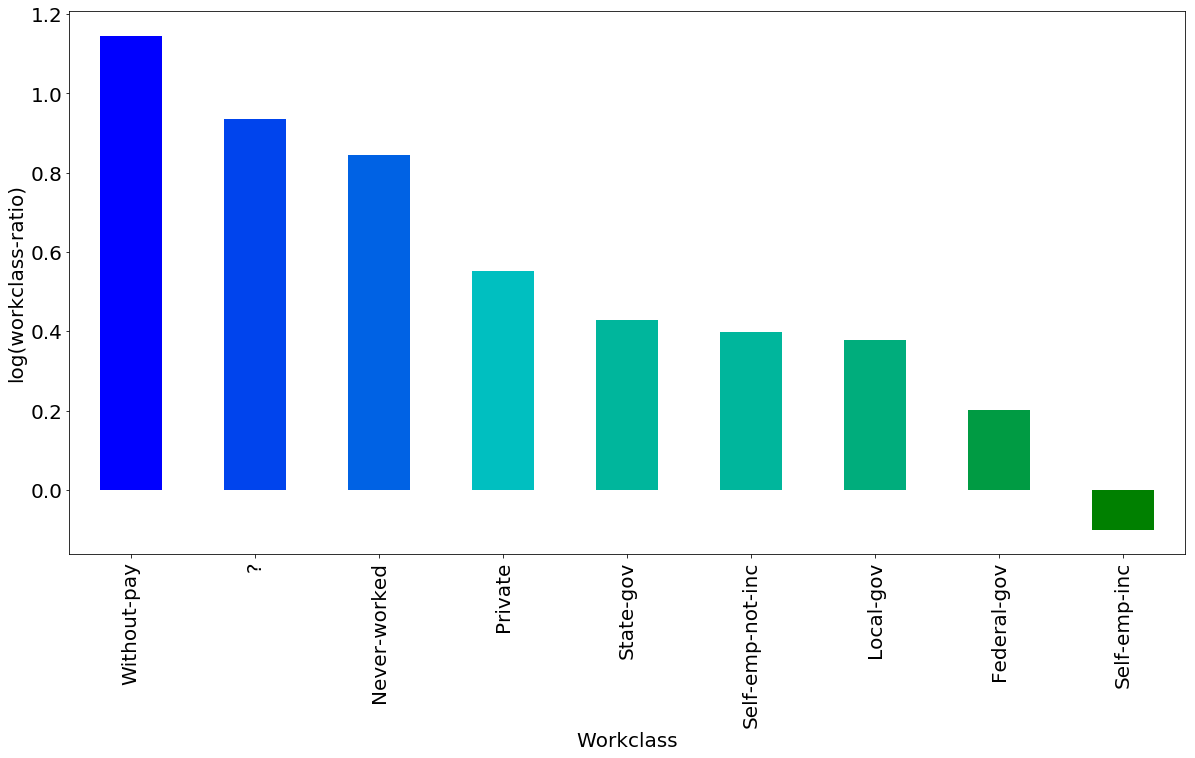

In [152]:
df_wc_groupby = plot_col_against_income(df, 'workclass', labels=['Workclass', 'Frequency'])

plot_group_ratio(df_wc_groupby, log_plot=False,\
                                                  labels=['Workclass', 'Workclass-ratio'], sort_val=True)

wc_ratio, wc_log_ratio = plot_group_ratio(df_wc_groupby, log_plot=True, labels=['Workclass', 'Workclass-ratio'],\
                                         sort_val=True)

### Marital-status plot

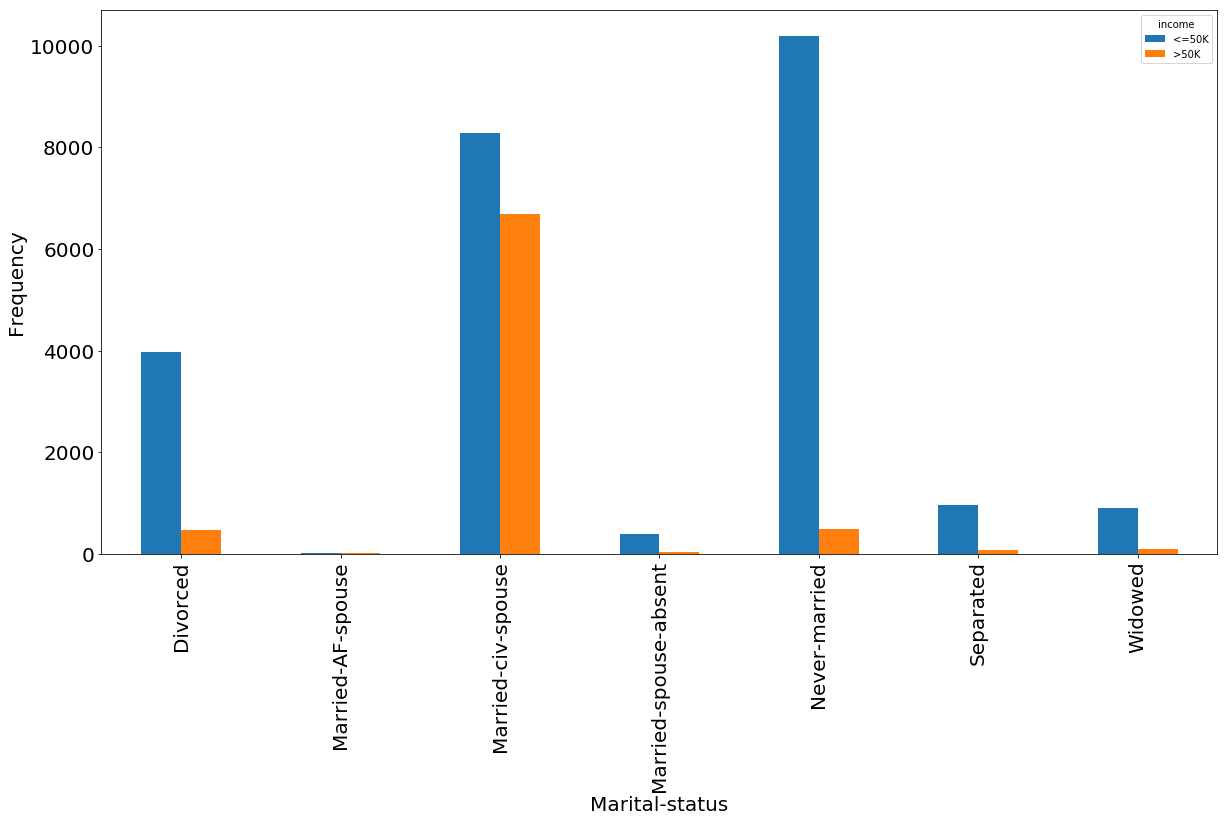

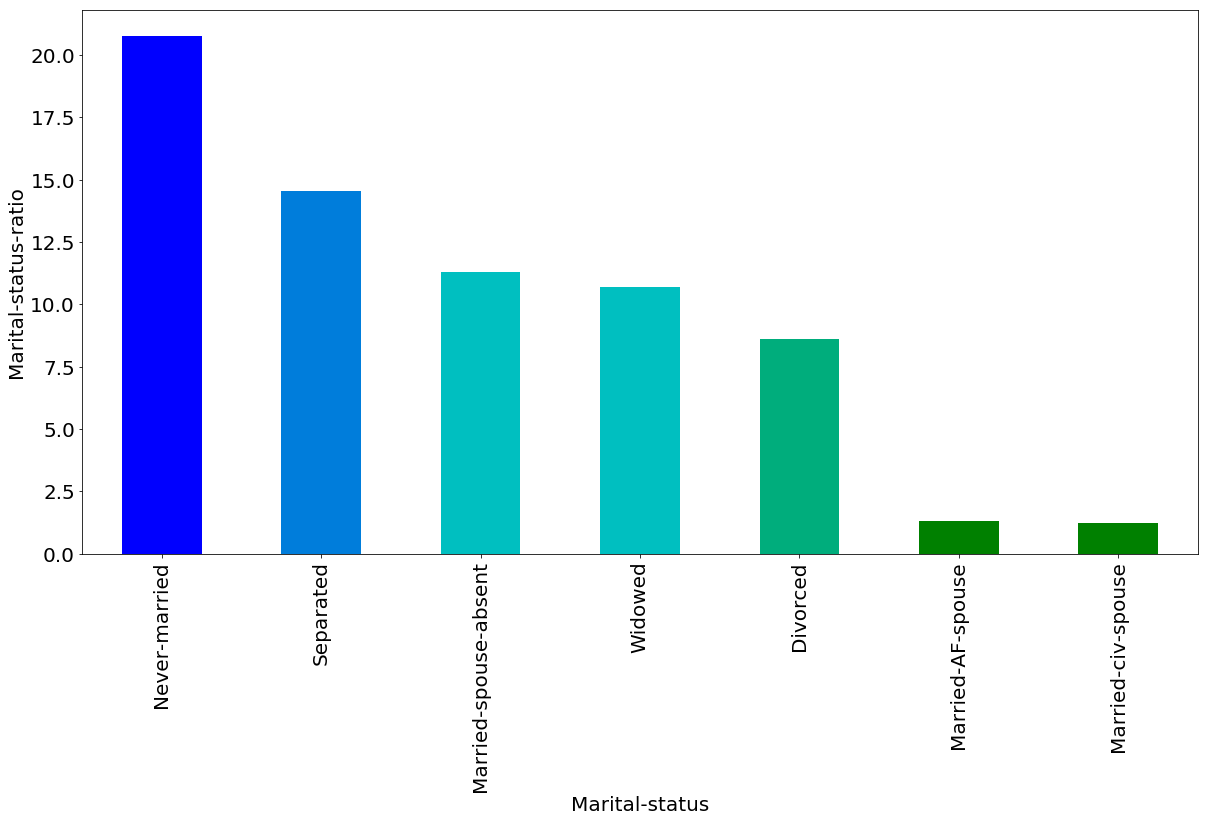

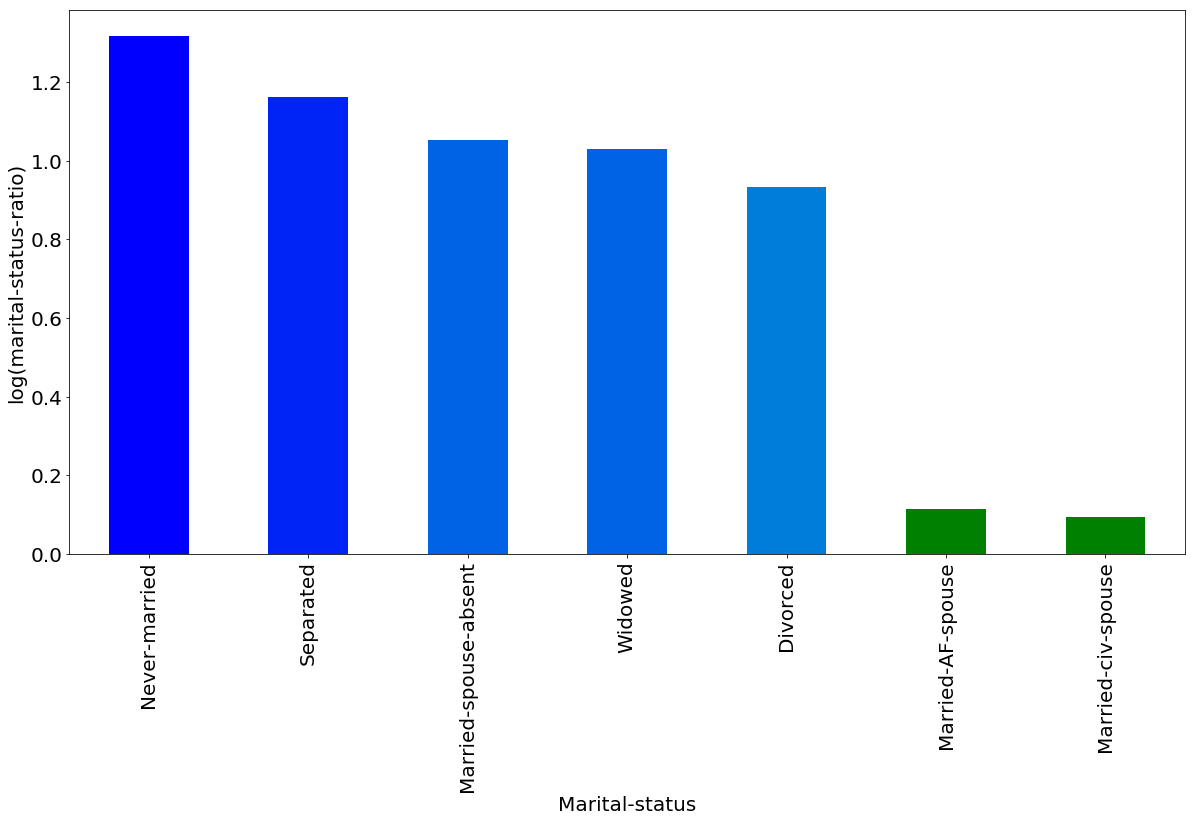

In [151]:
df_ms_groupby = plot_col_against_income(df, 'marital-status', labels=['Marital-status', 'Frequency'])

plot_group_ratio(df_ms_groupby, log_plot=False,\
                                                  labels=['Marital-status', 'Marital-status-ratio'], sort_val=True)

ms_ratio, ms_log_ratio = plot_group_ratio(df_ms_groupby, log_plot=True, \
                                          labels=['Marital-status', 'Marital-status-ratio'], sort_val=True)

**Comment on marital-status**<br>
Most people fall into 3 categories: married-civ-spouse, never-married and divorced.
Most of the categories have ratio values around 10, with the highest ratio of 20 for never married. Two categories, married-AF-spouse and marrie-civ-spouse categories, have low ratio values around 0.1. <br>

From this result, there are more people earning more than 50K in the married categories. This might suggest that, either marriage makes one earn more, or people earning more tend to get married. # TODO, see if there are any articles supporting either of these.

### Occupation plot

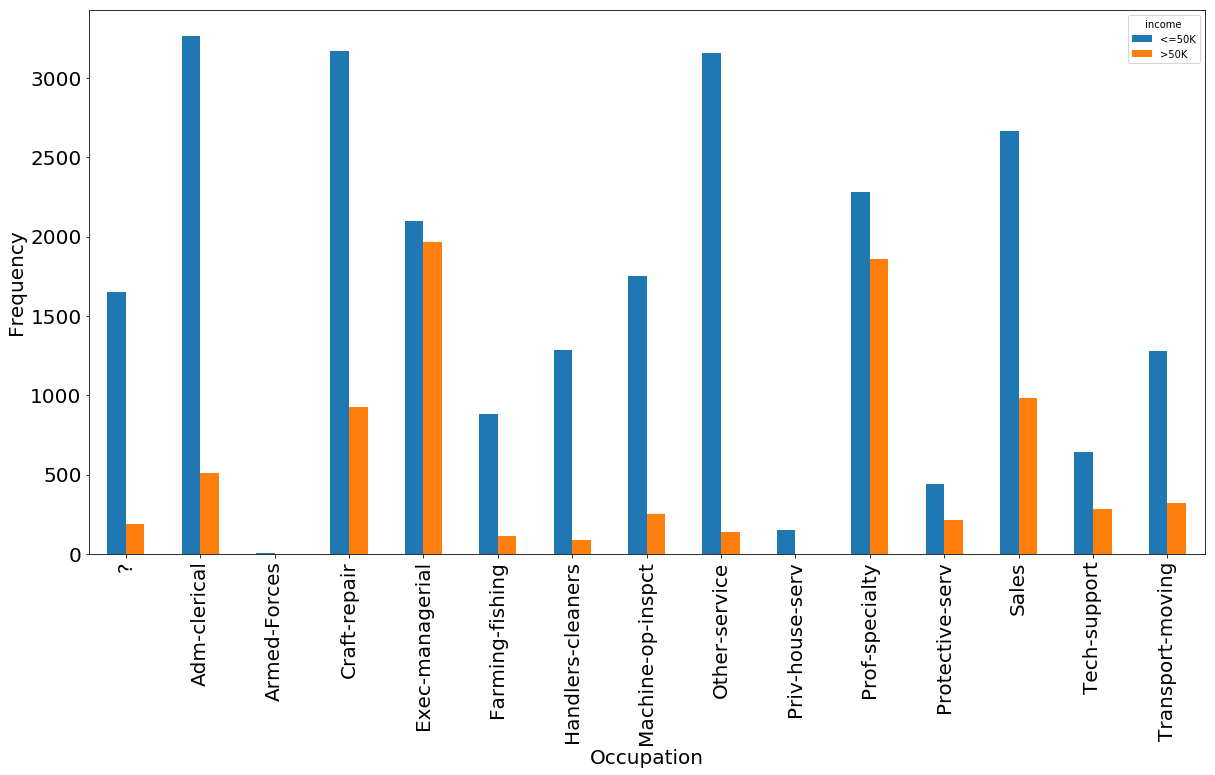

income
<=50K    148
>50K       1
Name: Priv-house-serv, dtype: int64


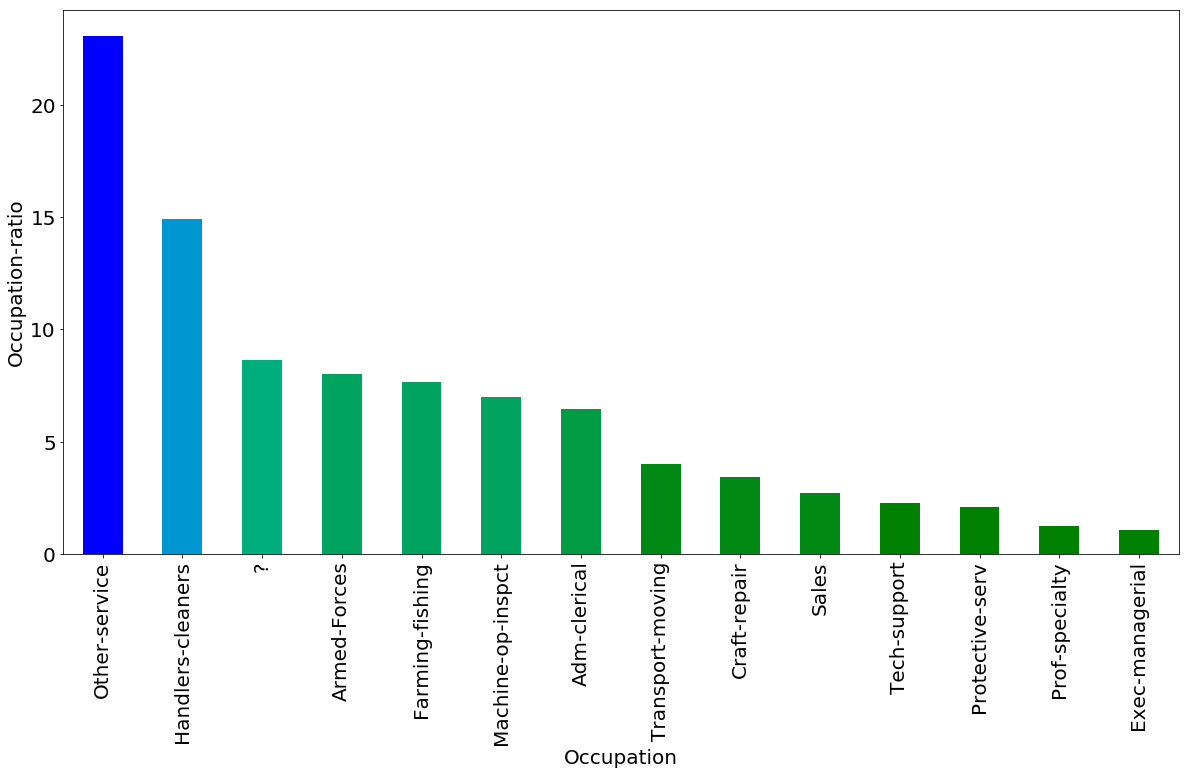

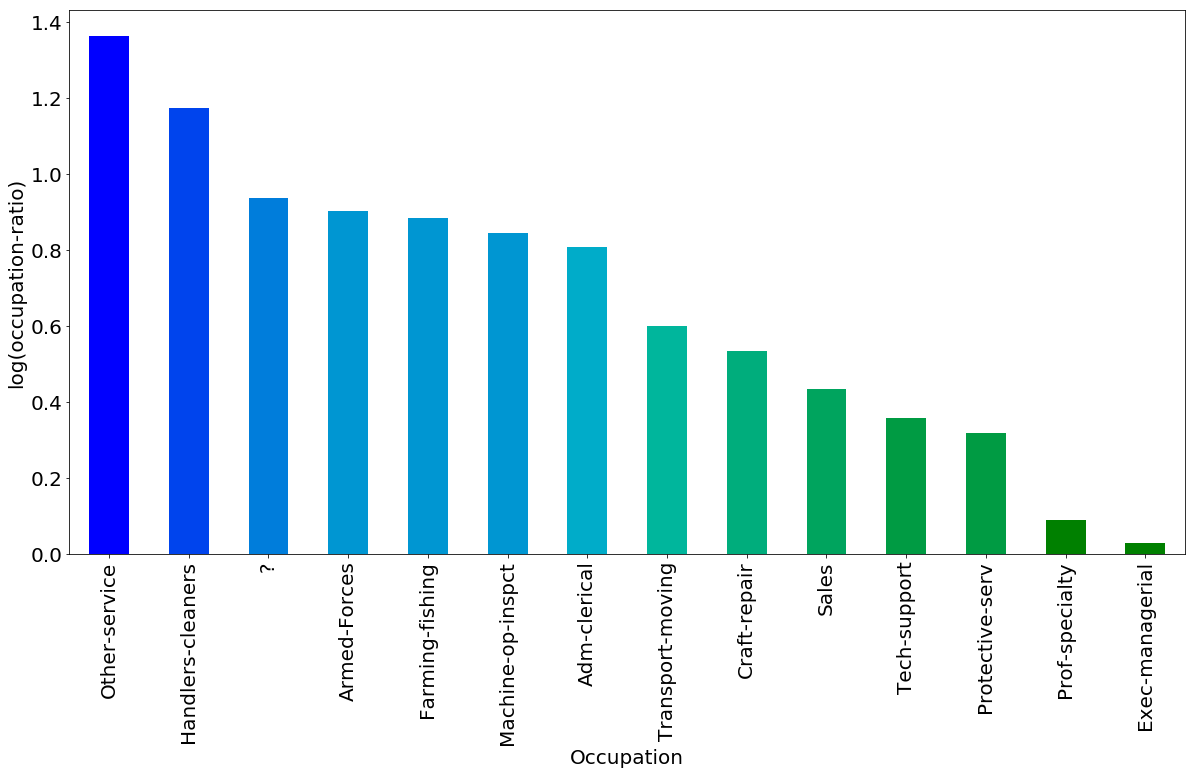

In [150]:
df_oc_groupby = plot_col_against_income(df, 'occupation', labels=['Occupation', 'Frequency'])

# print(df_oc_groupby.index)

print(df_oc_groupby.loc['Priv-house-serv'])

df_oc_groupby.drop(['Priv-house-serv'], axis=0, inplace=True)

# reindex = ["Other-service", "Handerls-cleaners", "?", "Adm-clerical", "Armed-Forces", "Farming-fishing", \
#            "Machine-op-inspct", "craft-repair", "exec-managerial", "Prof-specialty", "Protective serv", \
#            "Sales", "Tech-support", "Transport-moving"]

oc_ratio, oc_log_ratio = plot_group_ratio(df_oc_groupby, log_plot=False,\
                                                  labels=['Occupation', 'Occupation-ratio'], sort_val=True)

oc_ratio, oc_log_ratio = plot_group_ratio(df_oc_groupby, log_plot=True, labels=['Occupation', 'Occupation-ratio'],\
                                         sort_val=True)

**Comment on occupation**<br>
Take away Priv-house-serv category, which has substantially high ratio value of 148 compared to others, the rest of the occupations can be categorised into 3 groups based on the ratio values.

The 1st group has a ratio value above 10. This group includes "Other-service" and "Handerls-cleaners". <br>

The 2nd group has a ratio value between 5 to 10 and it contains "?", "Adm-clerical", "Armed-Forces", "Farming-fishing", "Machine-op-inspct".

The 3rd group has a ratio value below 5 and it includes "craft-repair", "exec-managerial", "Prof-specialty", "Protective serv", "Sales", "Tech-support", "Transport-moving".

### Native-country plot

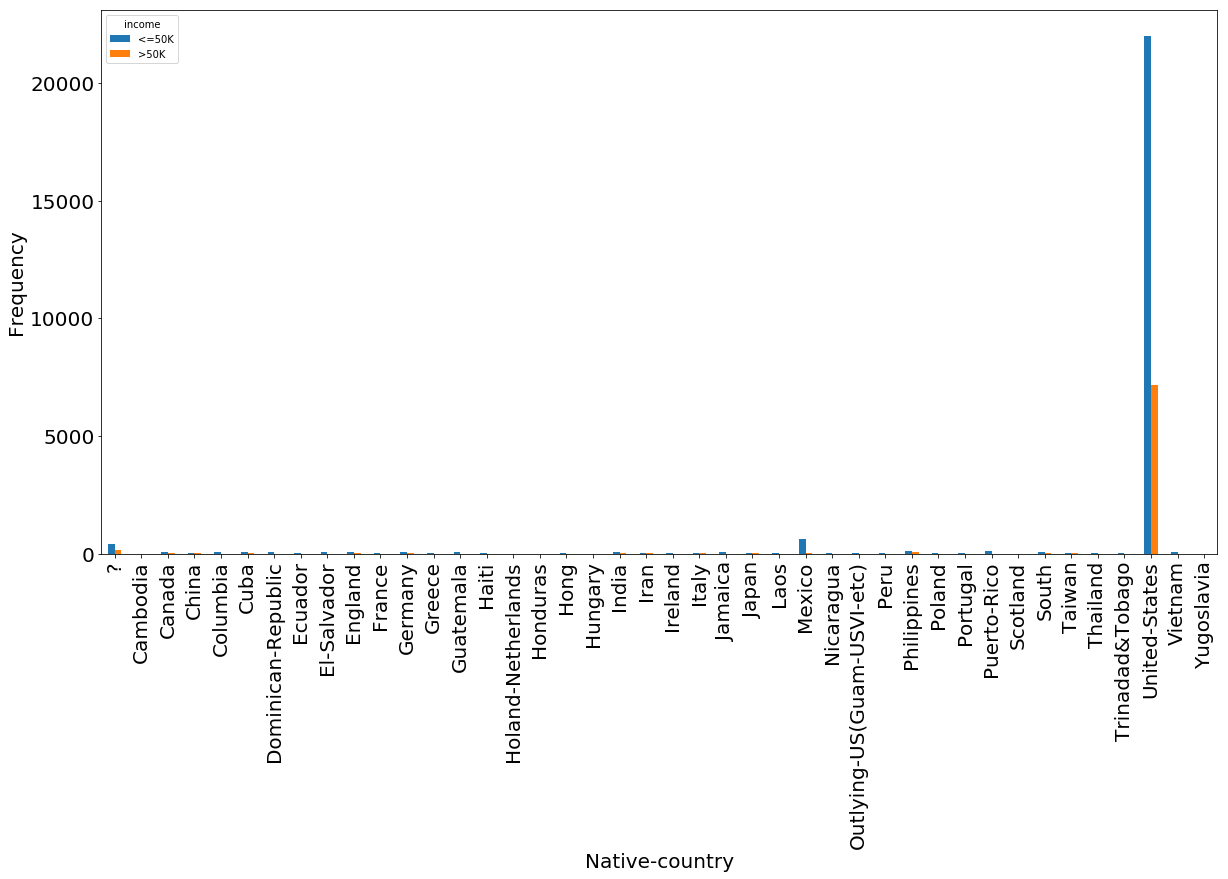

income                        <=50K    >50K
native-country                             
United-States               21999.0  7171.0
?                             437.0   146.0
Philippines                   137.0    61.0
Germany                        93.0    44.0
India                          60.0    40.0
Canada                         82.0    39.0
Mexico                        610.0    33.0
England                        60.0    30.0
Italy                          48.0    25.0
Cuba                           70.0    25.0
Japan                          38.0    24.0
China                          55.0    20.0
Taiwan                         31.0    20.0
Iran                           25.0    18.0
South                          64.0    16.0
Poland                         48.0    12.0
France                         17.0    12.0
Puerto-Rico                   102.0    12.0
Jamaica                        71.0    10.0
El-Salvador                    97.0     9.0
Greece                         2

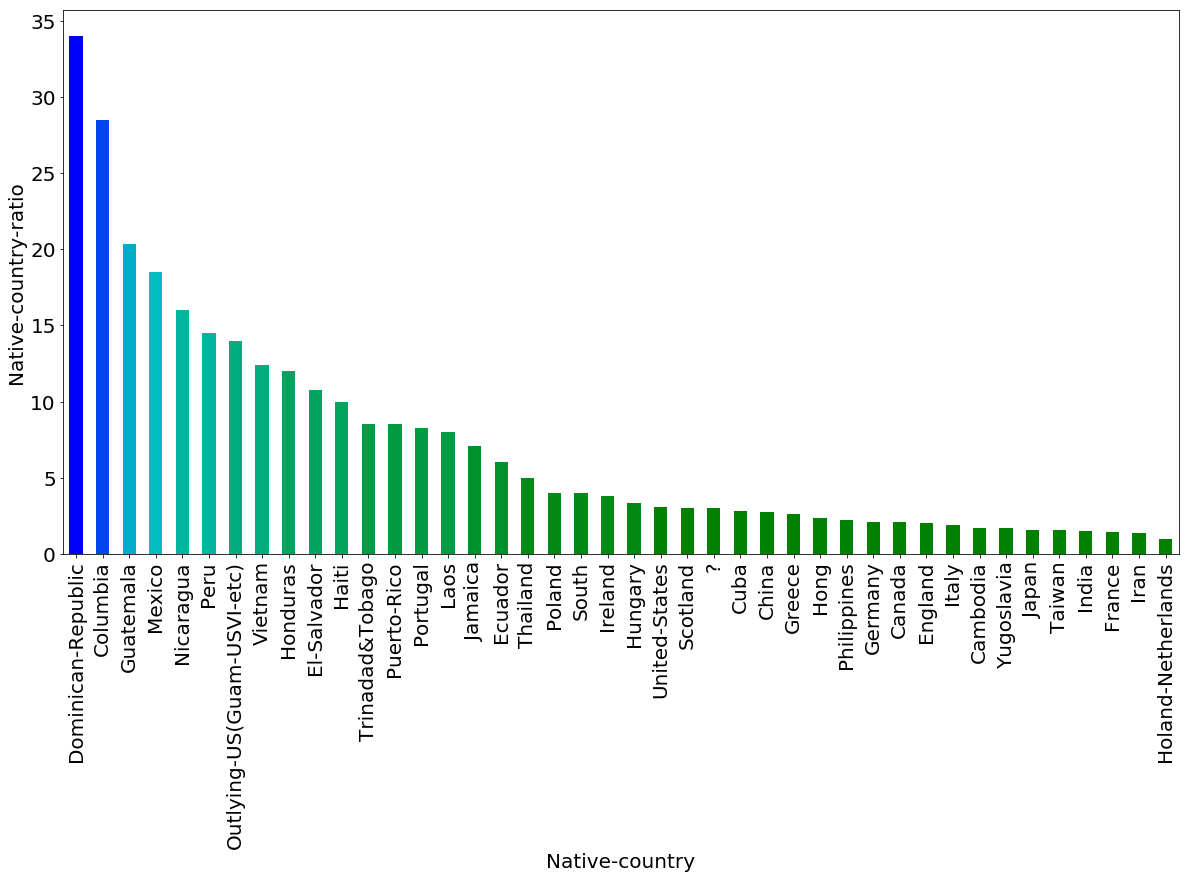

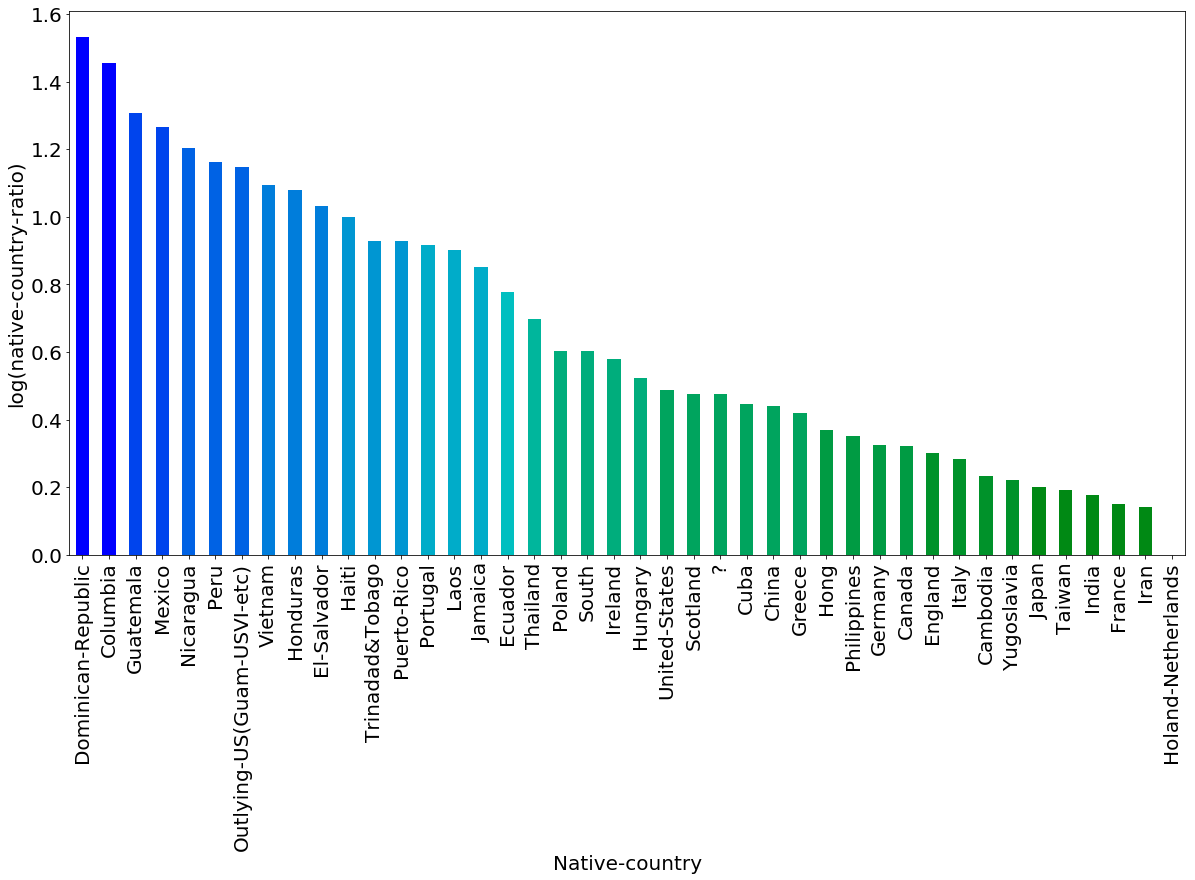

In [329]:
# edu_income_groupby = df.groupby(['education', 'income'])['age'].count().unstack()
# income_edu_groupby = df.groupby(['income', 'education'])['age'].count().unstack()
# # The order of income and education would affect the bar plot as demonstrated below
# print(df.groupby(['education', 'income'])['age'].count().unstack())

df_nc_groupby = plot_col_against_income(df, 'native-country', labels=['Native-country', 'Frequency'])
print(df_nc_groupby.sort_values(by=['>50K'], ascending=False).head(100))

plot_group_ratio(df_nc_groupby, log_plot=False,\
                                                  labels=['Native-country', 'Native-country-ratio'], sort_val=True)

nc_ratio, nc_log_ratio = plot_group_ratio(df_nc_groupby, log_plot=True, \
                                          labels=['Native-country', 'Native-country-ratio'], sort_val=True)

In [330]:
n_native_country = df_process.groupby(['native-country']).count()['age']

n_native_country.index = n_native_country.index.map(lambda x: x.strip())



nc_ratio = pd.concat([nc_ratio, n_native_country], axis=1)

print(nc_ratio)

# print(n_native_country.index)

                                    0    age
?                            2.993151    583
Cambodia                     1.714286     19
Canada                       2.102564    121
China                        2.750000     75
Columbia                    28.500000     59
Cuba                         2.800000     95
Dominican-Republic          34.000000     70
Ecuador                      6.000000     28
El-Salvador                 10.777778    106
England                      2.000000     90
France                       1.416667     29
Germany                      2.113636    137
Greece                       2.625000     29
Guatemala                   20.333333     64
Haiti                       10.000000     44
Holand-Netherlands           1.000000      1
Honduras                    12.000000     13
Hong                         2.333333     20
Hungary                      3.333333     13
India                        1.500000    100
Iran                         1.388889     43
Ireland   

### Further analysis on native country


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   native-country    ratios  count  country_gpp  country_eng_prof  nc_group
0               ?  2.993151    583       5692.0             50.00         0
1        cambodia  1.714286     19       1620.0             43.78         0
3           china  2.750000     75      10098.0             53.44         0
5            cuba  2.800000     95       8433.0             52.70         0
10         france  1.416667     29      41760.0             57.25         0
11        germany  2.113636    137      46563.0             63.77         0
12         greece  2.625000     29      19974.0             59.87         0
15    netherlands  1.000000      1      52367.0             70.27         0
17      hong kong  2.333333     20      49334.0             55.63         0
18        hungary  3.333333     13      17463.0             61.86         0
19          india  1.500000    100       2171.0             55.49         0
20           iran  1.388889     43       5506.0             48.69         0
22          

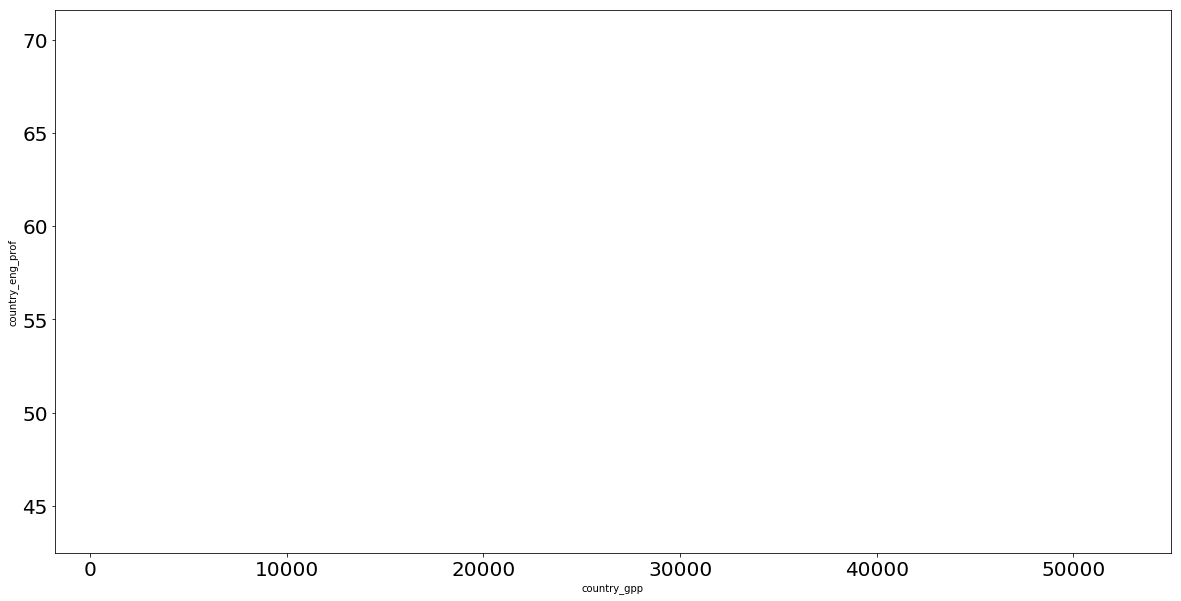

In [337]:
## Plot bivariate plot like what I often see in the Economist
# x-axis: native country's GPP
# y-axis: native country's English proficiency
# In the plot: use either circle size or colour to indicate the ratios.

# Check Pandas documentation for plotting the bivariate plot (line 56-61)

# print(df_process['country_gpp'].unique())

# nc_ratio.index = nc_ratio.index.map(lambda x: x.lower().strip())

if 'native-country' not in nc_ratio.columns:
    nc_ratio = nc_ratio.reset_index()
    nc_ratio.rename(columns={"0": "ratios", "index": "native-country", "age": "count"}, inplace=True)
    nc_ratio.replace(country_update, inplace=True)

    nc_ratio.rename(columns={0: "ratios"}, inplace=True)
    nc_ratio['native-country'] = nc_ratio['native-country'].apply(lambda x: x.lower().strip())
    nc_ratio['native-country'].replace(country_update, inplace=True)

    nc_ratio['country_gpp'] = nc_ratio['native-country']
    nc_ratio['country_gpp'].replace(country_gpp, inplace=True)
    nc_ratio['country_gpp'] = nc_ratio['country_gpp'].apply(lambda x: float(x))

    nc_ratio['country_eng_prof'] = nc_ratio['native-country']
    nc_ratio['country_eng_prof'].replace(country_eng_prof, inplace=True)
    nc_ratio['country_eng_prof'] = nc_ratio['country_eng_prof'].apply(lambda x: float(x))

    print(nc_ratio.head(10))

# df_nc_process = df_process.copy()
# df_nc_process.drop_duplicates(subset=['country_gpp', 'country_eng_prof'], inplace=True)
# print(df_nc_process.head(100))
# df_nc_process['country_gpp'] = df_nc_process['country_gpp'].apply(lambda x: int(x))
# df_nc_process['country_eng_prof'] = df_nc_process['country_eng_prof'].apply(lambda x: float(x))

eng_country = ['united states', 'united kingdom', 'australia', 'canada', 'new zealand',\
                            'outlying-us(guam-usvi-etc)', 'scotland', 'ireland', 'jamaica',\
                            'trinidad and tobago']

temp = nc_ratio[~nc_ratio['native-country'].isin(eng_country)]

# Assign the native countries to different groups based on the ratios
# Group I: ratio value in [0, 5)
# Geoup II: ratio value in [5, 10)
# Group III: ratio value in [10, 15)
# Group VI: ratio value > 15

temp['nc_group'] = 0
temp[temp['ratios'] < 5]['nc_group'] = 1
# temp[temp['ratios'] >= 5 & temp['ratios'] < 10]['nc_group'] = 2
# temp[temp['ratios'] >= 10 & temp['ratios'] < 15]['nc_group'] = 3
# temp[temp['ratios'] > 15]['nc_group'] = 4
print(temp[temp['ratios'] < 5])

# temp.plot(kind='scatter', x='country_gpp', y='country_eng_prof', s=temp['ratios']*20, \
#           c=temp["count"].apply(lambda x: math.log(x))*10,\
#               figsize=(20,10));
temp.plot(kind='scatter', x='country_gpp', y='country_eng_prof', s=temp['ratios']*20, \
          c=temp["nc_group"],\
              figsize=(20,10));

## Check the correlation between 
- GPP and ratio
- English proficiency and ratio
- GPP and Englis proficiency

In [323]:
nc_ratio[['ratios', 'country_gpp', 'country_eng_prof']].corr()

,ratios,country_gpp,country_eng_prof
ratios,1.000000,-0.36223,-0.208814
country_gpp,-0.362230,1.00000,0.607760
country_eng_prof,-0.208814,0.60776,1.000000


**Comment on correlation**<br>
The correlation between ratios and country_gpp/country_eng_prof is on the low end (0.2 - 0.35 range), which means that the correlation is not very strong.

In terms of the correlation between GPP and English proficiency, it has a Pearson's value of 0.6, suggesting that there is a weak linear relationship.

But coming back to the question, none of the two engineered parameters have strong correlation with the ratios. Therefore, adding these features do not add in much value.

In [213]:

# Update the country name so they are matching with the country name in the country_gpp dictionary
# temp_country_name = 
# temp_country_name.replace(country_update, inplace=True)
# # Create a new feature (column) and assign it first to native-country, then use replace function to get the corresponding gpp
# df_process['country_gpp'] = temp_country_name
# df_process['country_gpp'].replace(country_gpp, inplace=True)

native-country
dominican republic    34.000000
columbia              28.500000
guatemala             20.333333
mexico                18.484848
nicaragua             16.000000
dtype: float64

## Start feature engineering

In [ ]:
# TODO what should be done for left-skewed data with continuous x values?


In [123]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def label_encode(df, X_col, label_encode_col):
# y_encode_col = 'income'

    LEncoder = LabelEncoder()
    OHEncoder = OneHotEncoder()

    X_label_enc = df[X_col]

    for col in label_encode_col:
        # The column names have a space in front. Clear it
    #     cleaned_col = col.replace(' ', '')
    #     print(cleaned_col)

        ## TODO Fixed the empty space in front of the column name
        temp_dummy = pd.get_dummies(X_label_enc[col],prefix=col,prefix_sep='-')
        cleaned_val = [c.replace(' ','') for c in temp_dummy.columns]
        cleaned_cols = {k:v for (k,v) in zip(temp_dummy.columns, cleaned_val)}
    #     print(cleaned_cols)
        temp_dummy.rename(columns=cleaned_cols, inplace=True)
    #     print('temp_dummy.columns:', temp_dummy.head(2))
        X_label_enc.drop(columns=col, inplace=True)
        X_label_enc = X_label_enc.merge(temp_dummy, left_index=True, right_index=True)
    #     print(X_label_enc.columns)

    #     print(X)
    # Use for loop to fit and trasnform each column that needs to be encoded
    #     X_label_enc[col] = LEncoder.fit_transform(X_label_enc[col])
    #     X_label_enc[col] = OHEncoder.fit_transform(X_label_enc[col].reshape(-1,1))


    # print(pd.get_dummies(X_label_enc['workclass']))

    # LEncoder.fit_transform(df[columns[0]])
    y_encode = LEncoder.fit_transform(y)

    print(X_label_enc.columns)
    
    return X_label_enc, y_encode
    
    

    
    
label_encode_col = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

X_label_enc, y_encode = label_encode(df, X_col, label_encode_col)

print(y_encode)

X_label_enc.head()



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'workclass-?',
       'workclass-Federal-gov', 'workclass-Local-gov',
       'workclass-Never-worked', 'workclass-Private', 'workclass-Self-emp-inc',
       'workclass-Self-emp-not-inc', 'workclass-State-gov',
       'workclass-Without-pay', 'education-10th', 'education-11th',
       'education-12th', 'education-1st-4th', 'education-5th-6th',
       'education-7th-8th', 'education-9th', 'education-Assoc-acdm',
       'education-Assoc-voc', 'education-Bachelors', 'education-Doctorate',
       'education-HS-grad', 'education-Masters', 'education-Preschool',
       'education-Prof-school', 'education-Some-college',
       'marital-status-Divorced', 'marital-status-Married-AF-spouse',
       'marital-status-Married-civ-spouse',
       'marital-status-Married-spouse-absent', 'marital-status-Never-married',
       'marital-status-Separated', 'marital-status-Widowed', 'occupation-?',
    

,age,education-num,capital-gain,capital-loss,hours-per-week,native-country,workclass-?,workclass-Federal-gov,workclass-Local-gov,workclass-Never-worked,...,relationship-Own-child,relationship-Unmarried,relationship-Wife,race-Amer-Indian-Eskimo,race-Asian-Pac-Islander,race-Black,race-Other,race-White,gender-Female,gender-Male
0,39,13,2174,0,40,United-States,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,13,0,0,13,United-States,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,9,0,0,40,United-States,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,7,0,0,40,United-States,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,13,0,0,40,Cuba,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


## Native-country engineering
There are two ways that I came up with for native-country engineering.
1. Easy one, just separate native country to US and non-US
2. More complicated one: US still stays as US, for others, use two-dimensions to separate them: country GDP and English-speaking or not 
    * Easy version: 0 for English NOT as an official language; 1 for English as an official language
    * Complicated version: Use English speaking fluency to categorise, check the Economist).

## Getting country's GPP

In [178]:
import requests
from bs4 import BeautifulSoup


page = requests.get("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita")
# page.content

soup = BeautifulSoup(page.content, 'html.parser')
# print(soup.prettify())



In [179]:
list(soup.find("table"))
main_table = soup.find_all("table")
# print(main_table)
wikitable = soup.find_all("table", class_="wikitable")
# print(wikitable)

IMF_2019_table = wikitable[0]
tbody = IMF_2019_table.find("tbody")

# df_gpp = pd.DataFrame(columns=['country', 'GPP'])

country_update = {"united-states": "united states", "puerto-rico": "puerto rico", "england": "united kingdom", \
                 "dominican-republic": "dominican republic", "el-salvador": "el salvador", "hong": "hong kong", \
                 "holand-netherlands": "netherlands", "south": "south africa", "trinadad&tobago": "trinidad and tobago"}

# list_temp = []
country_gpp = {}

# i = 0
entries = tbody.find_all("tr")
for entry in entries:
    title = entry.find('a')['title'].lower()
    
#     print(title)
    GPP_temp = entry.find_all('td')
    if GPP_temp:
        GPP = GPP_temp[2].text.replace(',', '').replace('\n', '')
        
        if title == "republic of ireland":
            title = "ireland"
        
        country_gpp[title] = GPP
#         dict_temp = {}
#         dict_temp['country'] = title
#         dict_temp['GPP'] = GPP
#         list_temp.append(dict_temp)
#         print(dict_temp)
#         print(GPP)
# print(list_temp)

# Additional country GPP from other sources
country_gpp.update({'cuba': 8433, 'columbia': 6301, 'yugoslavia': 14949, 'scotland': 43740, 'outlying-us(guam-usvi-etc)': 35562,\
              '?': 5692})


# Cuba:, take 2017 United Nation data
# Columbia: 2017 Google
# Yugoslavia: broke into several countries: Croatia, Serbia, Slovenia, Bosnia and Herzegovina, Montenegro, Macedonia (Kosovo?)
# Take Croatia 
# Scotland: given in other section on the same page, 43740
# outlying-us(guam-usvi-etc): take Guam's 2016 Google, 35562
# Set "?" to the median value, which is Paraguay
# for key, val in country_gpp.items():
#     dict_temp = {}
#     dict_temp['country'] = key
#     dict_temp['GPP'] = val
#     list_temp.append(dict_temp)


# df_gpp = pd.DataFrame(list_temp)

# cols = ['country', 'GPP']
# df_gpp = df_gpp[cols]

# df_gpp.loc

# df_gpp.head()
# print(country_gpp)

In [181]:
# Print out the gpp countries to compare with df_process countries to see what names are not matching
# print(df_gpp['country'].apply(lambda x: x.lower()).unique())

# print(df_process['native-country'].apply(lambda x: x.lower().strip()).unique())

# Make a dictionary that helps to convert the format/naming of countries in the dataframe so that they match the ones in
# the df_gpp


In [194]:
# Update the country name so they are matching with the country name in the country_gpp dictionary
temp_country_name = df_process['native-country'].apply(lambda x: x.lower().strip())
temp_country_name.replace(country_update, inplace=True)
# Create a new feature (column) and assign it first to native-country, then use replace function to get the corresponding gpp
df_process['country_gpp'] = temp_country_name
df_process['country_gpp'].replace(country_gpp, inplace=True)
# df_process.replace({'country_gpp': })
# print(df_process)

## Getting each country's English score

In [183]:
# from selenium import webdriver
# Use Selenium to change the option selection.
# Not the ideal method, but it is simple.


# driver = webdriver.Firefox()
# driver.get('https://ceoworld.biz/2019/11/05/revealed-the-worlds-best-non-native-english-speaking-countries-2019/')
# driver.find_element_by_xpath("//select[@name='tablepress-350_length']/option[@value='100']").click()
# page = driver.page_source
page = requests.get('https://ceoworld.biz/2019/11/05/revealed-the-worlds-best-non-native-english-speaking-countries-2019/')
soup = BeautifulSoup(page.content, 'html.parser')

In [198]:
table = soup.find('table', id='tablepress-350')
# print(table)

eng_speaking = ['united states', 'united kingdom', 'australia', 'canada', 'new zealand', 'outlying-us(guam-usvi-etc)',\
               'scotland', 'ireland', 'jamaica', 'trinidad and tobago']

country_eng_prof = {'honduras': 50.09, 'columbia': 47.81, 'laos': 43.78, 'haiti': 52.58, '?': 50, \
                    'puerto rico': 52.58, 'yugoslavia': 63.07}
# Honduras: next to El Salvador, so use the same score
# Columbia: next to Venezuela, so use the same score
# Laos: next to Cambodia, so use the same score
# Haiti: next to Dominican Republic, so use the same score
# ?: give a median score of 50
# puerto rico: although English is one of the official language, it is not spoken fluently. 
# next to Dominican Republic, so use the same score
# yugoslavia: take Croatia

# list_temp = []

entries = table.find_all('tr')
for entry in entries:
    country_temp = entry.find('td', class_='column-2')
    if country_temp:
        country = country_temp.get_text().lower()
        eng_prof = entry.find('td', class_='column-3').get_text()
        country_eng_prof[country]= eng_prof
#         dict_temp = {}
#         dict_temp['country'] = country
#         dict_temp['eng_prof'] = eng_prof
#         list_temp.append(dict_temp)
#     print(entry)
#         print(country)
#         print(eng_prof)
        
for c in eng_speaking:
    country_eng_prof[c] = 100
#     dict_temp = {}
#     dict_temp['country'] = c
#     dict_temp['eng_prof'] = 100
#     list_temp.append(dict_temp)
    
# df_eng_prof = pd.DataFrame(list_temp)

# df_eng_prof.head(105)
print(country_eng_prof)

{'honduras': '50.53', 'columbia': 47.81, 'laos': 43.78, 'haiti': 52.58, '?': 50, 'puerto rico': 52.58, 'yugoslavia': 63.07, 'netherlands': '70.27', 'sweden': '68.74', 'norway': '67.93', 'denmark': '67.87', 'singapore': '66.82', 'south africa': '65.38', 'finland': '65.34', 'austria': '64.11', 'luxembourg': '64.03', 'germany': '63.77', 'poland': '63.76', 'portugal': '63.14', 'belgium': '63.09', 'croatia': '63.07', 'hungary': '61.86', 'romania': '61.36', 'serbia': '61.3', 'kenya': '60.51', 'switzerland': '60.23', 'philippines': '60.14', 'lithuania': '60.11', 'greece': '59.87', 'czech republic': '59.3', 'bulgaria': '58.97', 'slovakia': '58.82', 'malaysia': '58.55', 'argentina': '58.38', 'estonia': '58.29', 'nigeria': '58.26', 'costa rica': '57.38', 'france': '57.25', 'latvia': '56.85', 'hong kong': '55.63', 'india': '55.49', 'spain': '55.46', 'italy': '55.31', 'south korea': '55.04', 'taiwan': '54.18', 'uruguay': '54.08', 'china': '53.44', 'macau': '53.34', 'chile': '52.89', 'cuba': '52.7'

In [199]:
# Check what countries are missing and what country name is inconsistent with the country name downloaded from website table
# print(df_eng_prof['country'].unique())
# print(df_process['native-country'].apply(lambda x: x.lower().strip()).unique())

In [200]:
# Update the country name so they are matching with the country name in the country_gpp dictionary
temp_country_name = df_process['native-country'].apply(lambda x: x.lower().strip())
temp_country_name.replace(country_update, inplace=True)
# Create a new feature (column) and assign it first to native-country, then use replace function to get
# the corresponding English fluency
df_process['country_eng_prof'] = temp_country_name
df_process['country_eng_prof'].replace(country_eng_prof, inplace=True)

df_process.head(100)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,country_gpp,country_eng_prof
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1,65111,100
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1,65111,100
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,65111,100
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1,65111,100
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1,8433,52.7
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1,65111,100
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1,5460,100
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,0,65111,100
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,0,65111,100
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,0,65111,100


#### Clustering of the countries
Becasue there are too many countries for effective analysis, and also there is few people in some countries, I am going to cluster the countries based on the two features (GPP and English proficiency) to reduce the number of categories.

In [115]:
# Native country to be engineered further.
# Maybe use some factors to categorise countries such as: 
# 1. GPP (Gross average per person)
# https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita
# 2. Cultural similarities (maybe simply English-speaking and non-English speaking?)
# https://www.economist.com/graphic-detail/2019/12/04/where-are-the-worlds-best-english-speakers
# https://ceoworld.biz/2019/11/05/revealed-the-worlds-best-non-native-english-speaking-countries-2019/
# 3. Geographical location (continent)


# Easy version
US_check = ['united-states', 'outlying-us(guam-usvi-etc)']

# Need to do strip because there is weird space in entries
temp_native_country = df_process['native-country'].apply(lambda x: 1 if x.lower().strip() in US_check else 0)

native_country_dummy = pd.get_dummies(temp_native_country, prefix='native-country: US or not', prefix_sep='-')


df_process = df_process.merge(native_country_dummy, left_index=True, right_index=True)

# print(df_process['native-country'][0].lower().strip())

# print(df_process['native-country'].value_counts())
# print(temp_n_country)
# print(native_country_dummy)
df_process.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,...,"capital-loss_binned-(1617.0, 1876.0]","capital-loss_binned-(1876.0, 1902.0]","capital-loss_binned-(1902.0, 2001.0]","capital-loss_binned-(2001.0, 4356.0]","education-num_binned-(0.999, 9.0]","education-num_binned-(9.0, 10.0]","education-num_binned-(10.0, 13.0]","education-num_binned-(13.0, 16.0]",native-country: US or not-0,native-country: US or not-1
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,0,0,0,0,0,0,1,0,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,0,0,0,0,0,0,1,0,0,1
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,0,0,0,0,1,0,0,0,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,0,0,0,0,1,0,0,0,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
# More complicated method
# Get the GDP and English fluency information
dict_country_GDP = {}
dict_country_Eng_fluency = {}

temp_country_GDP # bin this using qcut
temp_Eng_fluency # bin this using qcut

## Functions that perform vertical quartile quantification and then horizontal binning
Since several columns require the same procedure (age, capital-gain and capital-loss), will write functions here
for calling <br>
For capital-gain and capital-loss, because there are too many different horizontal values (different amount of capital-gain/capital-loss, thus, would just use a horizontal qcut and omit the vertical one. <br><br>
Because most people have 0 capital-gain, most quartiles are concentrated close to 0 too.
By setting duplicate drop, don't get to see a lot of different bins even though quartile cut is big

## Capital-gain and capital-loss analysis
There are too many different values for capital-gain and capital-loss (and quite a few outliers).
So similar to age feature engineering, I will use a vertical quartile quantification method to limit the horizontal ranges.
The amount of money is again a continuous value, so might have to consider to similar things as age featuring
where I do the horizontal binning based on levels

In [99]:
def bin_num_col(df, col, q_num, drop_zero=False):
    # binning numerical columns with qcut. col should just be one column string. q_num is the number of bins to be made
    # if drop_zero=True, set zero as one of the bin then drop it, then perform qcut with the rest
    # print(df_process['capital-gain'])
    # df_process['capital-gain'].value_counts() # Most people have 0 capital-gain (perhaps no investment?)
    binned = []
#     temp_df = df.copy()
    
    if drop_zero == True:
        binned.extend([-0.01, 0.01])
        temp_df = df[(df[col] < -0.01) | (df[col] > 0.01)][col]
        print(temp_df)
    else:
        temp_df = df[col]
    
    if col in df.columns:
        ser, temp_binned = pd.qcut(temp_df, q=q_num, duplicates="drop", retbins=True)
        # With retbins=True, pd.qcut returns a tuple whose second element is the bins
        # The first return element is a series while the second one is the break point
        binned.extend(temp_binned)
        print(binned)

        # bin_cap_gain -= 0.01
        # Need to do this because the cut is excluding the left hand side boundary value, which means 0 would not
        # be include in (0 x]

        binned_col = pd.cut(df[col], bins=binned, include_lowest=True)

        binned_dummy = pd.get_dummies(binned_col,prefix= col + '_binned',prefix_sep='-')
#         df.drop(columns=[col], inplace=True)  
        df = df.merge(binned_dummy, left_index=True, right_index=True)
    
    return df

df_process = bin_num_col(df_process, 'capital-gain', 5, drop_zero=True)
df_process = bin_num_col(df_process, 'capital-loss', 5, drop_zero=True)
df_process = bin_num_col(df_process, 'education-num', 5)

# ser, bin_cap_gain = pd.qcut(df_process['capital-gain'], q=50, duplicates="drop", retbins=True)
# df_process['capital_gain_binned'] = pd.cut(df_process['capital-gain'], bins=bin_cap_gain, include_lowest=True)

# cap_gain_binned_dummy = pd.get_dummies(df_process['capital_gain_binned'],prefix='capital_gain_binned',prefix_sep='-')

# # getting rid of old columns:
# # 'capital-gain'
# # 'capital_gain_binned'
# df_process.drop(columns=['capital_gain_binned'], inplace=True)  
# df_process = df_process.merge(cap_gain_binned_dummy, left_index=True, right_index=True)


# bin_log_age_ratio.to_frame().T.plot.bar()
# # test.to_frame().plot.bar()

# print(bin_boundary)
# df_process[['age','age_binned']].head()
df_process.head()

0         2174
8        14084
9         5178
59        5013
60        2407
84       14344
101      15024
105       7688
106      34095
113       4064
132       4386
197      14084
198       7298
206       7298
208      15024
227       1409
230       3674
263       4064
271       1055
272       2407
276       7298
279       7298
281       5178
285      15024
297       3464
300       7688
303       4386
311       7298
329       2050
341       7298
         ...  
32098     7298
32123    13550
32139    15024
32155     1055
32156     7298
32164    10520
32169     4101
32179     5178
32198    20051
32203    15024
32228     7688
32238    99999
32249     7688
32308     3103
32341    15831
32354     6849
32365    15024
32367     2653
32370    27828
32388     1471
32399     7298
32434     7443
32462     7298
32466    15024
32473     1506
32515     3471
32518    99999
32538    15020
32548     1086
32560    15024
Name: capital-gain, Length: 2712, dtype: int64
[-0.01, 0.01, 114.0, 3103.0, 5013.0, 7

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,...,"capital-loss_binned-(0.01, 155.0]","capital-loss_binned-(155.0, 1617.0]","capital-loss_binned-(1617.0, 1876.0]","capital-loss_binned-(1876.0, 1902.0]","capital-loss_binned-(1902.0, 2001.0]","capital-loss_binned-(2001.0, 4356.0]","education-num_binned-(0.999, 9.0]","education-num_binned-(9.0, 10.0]","education-num_binned-(10.0, 13.0]","education-num_binned-(13.0, 16.0]"
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,0,0,0,0,0,0,0,0,1,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,0,0,0,0,0,0,0,0,1,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,0,0,0,0,0,0,1,0,0,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,0,0,0,0,0,0,1,0,0,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
# Similarly perform the same with capital-loss
df_process['capital-loss'].describe()

bin_cap_loss = pd.qcut(df_process['capital-loss'], q=50, duplicates="drop")

print(bin_cap_loss.value_counts())
print(df_process[df_process['capital-loss'] < 1590]['capital-loss'].value_counts())

# df_process['capital-gain'].value_counts()

(-0.001, 1590.0]    31288
(1590.0, 1902.0]      738
(1902.0, 4356.0]      535
Name: capital-loss, dtype: int64
0       31042
1485       51
1564       25
1408       21
1579       20
1504       18
625        12
1092        7
1380        7
1340        7
1573        6
880         6
213         4
1258        4
419         3
323         3
653         3
810         2
1138        2
974         2
1539        1
1411        1
155         1
Name: capital-loss, dtype: int64


### Age feature engineering
The ratio between people earning more than 50K and less than 50K changes with the age group.
With that, binning would be more effective if we can set the boundary at which the ratios change a lot.

1. In this example, all bins have more people earning less than 50K than people earning more than 50K. So the ratio would just be (Number of people earning less than 50K)/(Number of people earning more than 50K).
2. Some of the ratios can be huge (at young age) compared to low ratios. To reduce the effect of big ratio and increase the effect of smaller ratio change, log transfomration would be applied
3. Final step is to apply "Bayesian blocks", which is an adaptive method to find the optimal binning strategy

For a set of histogram bins or blocks, each of an arbirary size, one can use a Bayesain likelihood framework to compute a fitness function which only depeds on two numbers: the width of each block, and the number of points in each block. The edges betwen these blocks (the change-points) can be varied, and the overall block configuration with the maximum fitness is quantitatively the est binning.


In [10]:
def bayesian_blocks(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        print(fit_vec)
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

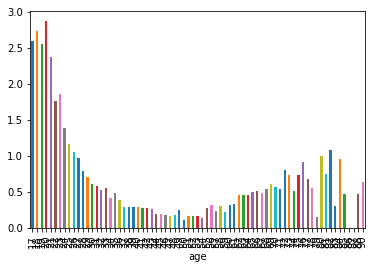

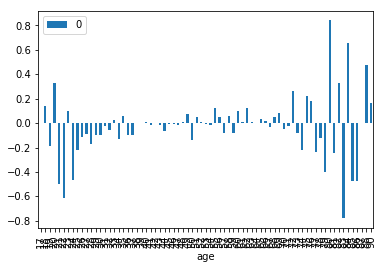

In [11]:
log_age_ratio_diff = log_age_ratio.to_frame().T.diff(axis=1)

log_age_ratio.plot.bar()
log_age_ratio_diff.T.plot.bar()

In [12]:
def get_hori_bound(s):
# This function takes in either series or a list of time-series like values that have been quantified with vertical qcut
# To reduce the number of discrete values in binning, a simple boundary values would be returned for horizontal qcut
# Within each boundary, the vertical (y-axis) values would be the same
# At the moment there is no smoothing method, bumpy vertical values within a long stretch of vertical values
# would have its own boundary

# The algorithm is simple too, whenever vertical value is the same, no boundary is set and move on to the next sample
# If the vertical value is different, then a boundary is set and the new vertical value is set
    bin_boundary = []
    prev_yval = None
    labels = []
    
#     curr_
    
    for row in s.iteritems():
        if not prev_yval or not row[1] == prev_yval:
            prev_yval = row[1]
#             print(row.index)
            bin_boundary.append(row[0])   
    

    return bin_boundary
            
        
    
    

In [22]:
vert_qcut_val = pd.qcut(log_age_ratio, 5)
print(vert_qcut_val.unique()[0].left)

print(vert_qcut_val.unique())

interval=[]
mid_val = []
labels = []

for v in vert_qcut_val.unique():
    interval.append(v.left)
    interval.append(v.right)
    mid_val.append((v.left + v.right)/2)
    
    
vert_qcut_list = sorted(set(interval))
mid_val_list = sorted(set(mid_val))

print(mid_val_list)
print(labels)

bin_log_age_ratio = pd.cut(x=log_age_ratio, bins=vert_qcut_list, labels=mid_val_list)

# bin_log_age_ratio.to_frame().T.plot.bar()
# test.to_frame().plot.bar()
bin_boundary = get_hori_bound(bin_log_age_ratio)

df_process['age-binned'] = pd.cut(df_process['age'], bins=bin_boundary)

age_binned_dummy = pd.get_dummies(df_process['age-binned'],prefix='age-binned',prefix_sep='-')

# df_process.drop(columns=col, inplace=True)
df_process = df_process.merge(age_binned_dummy, left_index=True, right_index=True)



print(bin_boundary)
# df_process[['age','age_binned']].head()
df_process.head()

0.872
[(0.872, 2.877], (0.546, 0.872], (0.372, 0.546], (0.245, 0.372], (-0.001, 0.245]]
Categories (5, interval[float64]): [(-0.001, 0.245] < (0.245, 0.372] < (0.372, 0.546] < (0.546, 0.872] < (0.872, 2.877]]
[0.122, 0.3085, 0.459, 0.7090000000000001, 1.8744999999999998]
[]
[17, 28, 32, 33, 34, 37, 44, 49, 50, 55, 57, 58, 59, 60, 62, 69, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90]


,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,...,"age_binned-(77, 79]_y","age_binned-(79, 80]_y","age_binned-(80, 81]_y","age_binned-(81, 82]_y","age_binned-(82, 83]_y","age_binned-(83, 84]_y","age_binned-(84, 85]_y","age_binned-(85, 86]_y","age_binned-(86, 88]_y","age_binned-(88, 90]_y"
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,0,0,0,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,0,0,0,0,0,0,0,0,0,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,0,0,0,0,0,0,0,0,0,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,0,0,0,0,0,0,0,0,0,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Perform automatic binning on continuous values

# test = pd.qcut(df['age'].values, 5, \
#                labels=['young', 'prime-time', 'middle-age','retiring', 'senior']) # Categorical if given is array

test = pd.qcut(df['age'], 10) # Categorical if given is array

print(test.value_counts())

(16.999, 22.0]    3895
(33.0, 37.0]      3518
(50.0, 58.0]      3461
(26.0, 30.0]      3376
(22.0, 26.0]      3301
(37.0, 41.0]      3245
(45.0, 50.0]      3167
(41.0, 45.0]      3008
(58.0, 90.0]      2999
(30.0, 33.0]      2591
Name: age, dtype: int64


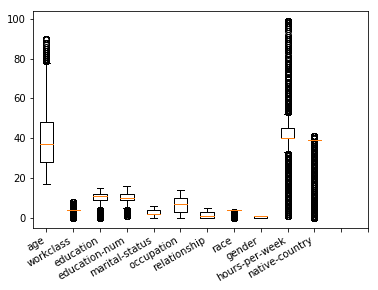

In [73]:
plt.boxplot(X_label_enc.drop(columns=['capital-gain', 'capital-loss'],axis=1).values)
plt.xticks(np.arange(1, X_label_enc.shape[1] + 1),
           X_col.drop(['capital-gain', 'capital-loss']), rotation=30, ha="right");

# Capital-gain and capital-loss have values much higher than others, so drop them.